# 初始化

In [1]:
# 环境与依赖

# 基础包
import tempfile

import os, gc, glob, json, yaml, time
from pathlib import Path
import numpy as np, pandas as pd, polars as pl
import lightgbm as lgb
from dataclasses import dataclass
import pyarrow.parquet as pq
from typing import Sequence, Optional, Union, List, Tuple, Iterable, Mapping

import matplotlib.pyplot as plt
# Azure & 文件系统
import fsspec
from getpass import getpass
from dotenv import load_dotenv
load_dotenv()  # 默认会加载当前目录下的 .env 文件


True

In [2]:
# 连接云空间

ACC = os.getenv("AZURE_STORAGE_ACCOUNT_NAME")
KEY = os.getenv("AZURE_STORAGE_ACCOUNT_KEY")
if not ACC or not KEY:
    raise RuntimeError("Azure credentials not found. Please set them in .env")
storage_options = {"account_name": ACC, "account_key": KEY}
fs = fsspec.filesystem("az", **storage_options)

In [3]:
# 定义路径辅助函数

import os, yaml, fsspec
from pathlib import Path

# 读取配置（唯一来源）
cfg = yaml.safe_load(open("exp/v1/config/data.yaml"))

# 路径辅助函数
def P(kind: str, *parts) -> str:
    """
    kind: 'az' | 'np' | 'local'
      az    -> 'az://<container>/<prefix>/...'
      np    -> '<container>/<prefix>/...'
      local -> '<local_root>/...'
    parts:  额外路径片段（可传 'a/b/c' 或 ('a','b','c')）
    """
    container  = str(cfg["blob"]["container"]).strip("/")
    prefix     = str(cfg["blob"]["prefix"]).strip("/")
    local_root = Path(cfg["local"]["root"])

    segs = [str(p).strip("/") for p in parts if p]
    tail = "/".join(segs) if segs else ""

    if kind == "az":
        base = "az://" + f"{container}/{prefix}" 
        return f"{base}/{tail}" if tail else base
    if kind == "np":
        base = f"{container}/{prefix}"
        return f"{base}/{tail}" if tail else base
    if kind == "local":
        return str(Path(local_root, tail))
    raise ValueError("kind must be 'az', 'np', or 'local'")


In [4]:
FEATURE_ALL = [f"feature_{i:02d}" for i in range(79)]

lb = pl.scan_parquet(P("az", cfg['paths']['raw']) + "/train.parquet/partition_id=*[4-8]/*.parquet", storage_options=storage_options)
lt = pl.scan_parquet(P("az", cfg['paths']['raw']) + "/train.parquet/partition_id=*[8-9]/*.parquet", storage_options=storage_options)

# EDA

In [ ]:
# EDA：每个交易日的symbol覆盖情况,是否覆盖全程
lf_s_d = lb.select(['date_id', 'symbol_id'])

per_date = (
    lf_s_d.group_by("date_id")
      .agg(pl.col("symbol_id").n_unique().alias("n_symbols"))
      .sort("date_id")
)

max_n = per_date.select(pl.max("n_symbols")).collect().item()
summary = per_date.with_columns([
    pl.lit(max_n).alias("max_n"),
    (pl.col("n_symbols") == max_n).alias("is_full_universe")
])

dates_missing = summary.filter(pl.col("is_full_universe") == False).select("date_id")
# summary.collect(); dates_missing.collect()

dates_missing.collect()

In [ ]:
# 先选一个横向，纵向都比较小的样本,按照data_id来选一小块快速试验

ls = lb.filter(pl.col('symbol_id').is_in([1,2,3,4,5]) & pl.col('date_id').is_in([1400,1420]))


# 数据预处理

Clip

In [ ]:
def rolling_sigma_clip(
    lf: pl.LazyFrame,
    features: Sequence[str],
    window: int = 50, # 可以一列一窗口
    k: float = 3.0,
    ddof: int = 0,
    min_valid: int = 10,
    cast_float32: bool = True,
) -> pl.LazyFrame:
    """
    对指定 features 做按 symbol_id 的滚动 kσ 裁剪。
    假设 lf 已经按 ['symbol_id','date_id','time_id'] 排好序。
    """
    lf = lf.select(pl.col(features + ['symbol_id', 'date_id', 'time_id']))
    over_cols = ["symbol_id"]
    # 确保标准差有定义：ddof=0 时至少 1 个样本，ddof=1 时至少 2 个样本
    min_need = max(min_valid, ddof + 1)

    exprs = []
    for c in features:
        x   = pl.col(c)
        cnt = x.is_not_null().cast(pl.Int32).rolling_sum(window_size=window, min_samples=1).over(over_cols)
        mu  = x.rolling_mean(window_size=window, min_samples=1).over(over_cols)
        sd  = x.rolling_std(window_size=window, ddof=ddof, min_samples=1).over(over_cols)

        lo, hi = mu - k * sd, mu + k * sd
        if cast_float32:
            x  = x.cast(pl.Float32)
            lo = lo.cast(pl.Float32)
            hi = hi.cast(pl.Float32)

        exprs.append(
            pl.when(cnt >= min_need).then(x.clip(lo, hi)).otherwise(x).alias(c)
        )

    return lf.with_columns(exprs)




In [ ]:
# Clip features - train


lf_clip = rolling_sigma_clip(
    lf=lb,
    features=FEATURE_ALL
)
lf_clip = lf_clip.sort(cfg['keys'])

lf_clip.collect(streaming=True).write_parquet(f"{P('local', cfg['paths']['cache'])}/clip.parquet", compression="zstd")

Impute

In [ ]:
def causal_impute(
    lf: pl.LazyFrame,
    features: Sequence[str],
    open_ticks: Tuple[int, int] = (0, 10),
    carry_days: int = 5,
    intraday_limit: int = 100,
    same_tick_days: int = 5,
    ensure_sorted: bool = False,
) -> pl.LazyFrame:
    """严格因果的极简填补：
       1) 开盘段：按 symbol 跨日 ffill（TTL）
       2) 全日：按 (symbol,date) 日内 ffill（可限步数）
       3) 可选：同一 time_id 跨日 ffill（TTL）
       不做任何均值/中位数/全局兜底。
    """
    if ensure_sorted:
        lf = lf.sort(["symbol_id", "date_id", "time_id"])

    t0, t1 = open_ticks
    is_open = pl.col("time_id").is_between(t0, t1)

    # --- 1) 开盘：跨日承接（带 TTL） ---
    open_exprs = []
    for c in features:
        # “上一次非空值所在的 date_id”（按 symbol）
        last_date = (
            pl.when(pl.col(c).is_not_null()).then(pl.col("date_id")).otherwise(None)
            .forward_fill().over("symbol_id")
        )
        cand = pl.col(c).forward_fill().over("symbol_id")
        gap  = (pl.col("date_id") - last_date).cast(pl.Int32)
        open_exprs.append(
            pl.when(is_open & pl.col(c).is_null()
                    & cand.is_not_null()
                    & last_date.is_not_null()
                    & (gap <= carry_days)
            ).then(cand).otherwise(pl.col(c)).alias(c)
        )
    lf1 = lf.with_columns(open_exprs)

    # --- 2) 日内 ffill（按 (symbol,date)）---
    if intraday_limit is None:
        lf2 = lf1.with_columns([
            pl.col(c).forward_fill().over(["symbol_id","date_id"]).alias(c)
            for c in features
        ])
    else:
        intra_exprs = []
        for c in features:
            cand_intra = pl.col(c).forward_fill().over(["symbol_id","date_id"])
            last_t = (
                pl.when(pl.col(c).is_not_null()).then(pl.col("time_id")).otherwise(None)
                .forward_fill().over(["symbol_id","date_id"])
            )
            step_gap = (pl.col("time_id") - last_t).cast(pl.Int32)
            intra_exprs.append(
                pl.when(pl.col(c).is_null()
                        & cand_intra.is_not_null()
                        & last_t.is_not_null()
                        & (step_gap <= intraday_limit)
                ).then(cand_intra).otherwise(pl.col(c)).alias(c)
            )
        lf2 = lf1.with_columns(intra_exprs)

    # --- 3) 同一 time_id 跨日承接（可选，带 TTL）---
    lf3 = lf2
    if same_tick_days is not None:
        tick_exprs = []
        for c in features:
            last_date_same = (
                pl.when(pl.col(c).is_not_null()).then(pl.col("date_id")).otherwise(None)
                .forward_fill().over(["symbol_id","time_id"])
            )
            cand_same = pl.col(c).forward_fill().over(["symbol_id","time_id"])
            gap2 = (pl.col("date_id") - last_date_same).cast(pl.Int32)
            tick_exprs.append(
                pl.when(pl.col(c).is_null()
                        & cand_same.is_not_null()
                        & last_date_same.is_not_null()
                        & (gap2 <= same_tick_days)
                ).then(cand_same).otherwise(pl.col(c)).alias(c)
            )
        lf3 = lf2.with_columns(tick_exprs)

    # --- 4) 再做一次日内 ffill（把 step 3 新填出的值向后传播） ---
    if intraday_limit is None:
        lf4 = lf3.with_columns([
            pl.col(c).forward_fill().over(["symbol_id","date_id"]).alias(c)
            for c in features
        ])
    else:
        post_exprs = []
        for c in features:
            cand = pl.col(c).forward_fill().over(["symbol_id","date_id"])
            last_t = (
                pl.when(pl.col(c).is_not_null()).then(pl.col("time_id")).otherwise(None)
                .forward_fill().over(["symbol_id","date_id"])
            )
            gap = (pl.col("time_id") - last_t).cast(pl.Int32)
            post_exprs.append(
                pl.when(pl.col(c).is_null() & cand.is_not_null()
                        & last_t.is_not_null() & (gap <= intraday_limit)
                ).then(cand).otherwise(pl.col(c)).alias(c)
            )
        lf4 = lf3.with_columns(post_exprs)

    return lf4.select(["symbol_id","date_id","time_id", *features])


In [ ]:
lf_clip = pl.scan_parquet(f"{P('local', cfg['paths']['cache'])}/clip.parquet")
lf_imp = causal_impute(
    lf=lf_clip,
    features=FEATURE_ALL,
    ensure_sorted=True
)

lf_imp.collect(streaming=True).write_parquet(f"{P('local', cfg['paths']['cache'])}/imp.parquet", compression="zstd")

In [ ]:
# 右边
rhs = lb.select(['symbol_id','date_id','time_id','weight', *RESP_COLS]).unique(subset=['symbol_id','date_id','time_id'])

# 左边
lf_imp = pl.scan_parquet(f"{P('local', cfg['paths']['cache'])}/imp.parquet")

dmin, dmax = (
    lf_imp.select(
        pl.col('date_id').min().alias('dmin'),
        pl.col('date_id').max().alias('dmax'),
    )
    .collect()
    .row(0)
)
path = P('az', 'exp/v1', cfg['paths']['clean'])
fs.makedirs(path, exist_ok=True)


print(f"Processing date range: {dmin} to {dmax}")

for lo in range(dmin, dmax + 1, BUCKET):
    hi = min(lo + BUCKET - 1, dmax)
    left  = lf_imp.filter(pl.col('date_id').is_between(lo, hi))
    right = rhs.filter(pl.col('date_id').is_between(lo, hi))
    part  = left.join(right, on=['symbol_id','date_id','time_id'], how='left')
    (
        part.collect(streaming=True)
            .write_parquet(f"{path}/imp_{lo}_{hi}.parquet",
                           compression='zstd',
                           storage_options=storage_options)
    )

In [ ]:
# 对文件排序

# 先提取文件列表
paths = fs.glob(f"{P('az', 'exp/v1', cfg['paths']['clean'])}/*.parquet")

# 按文件名中的起点时间排序

start_points = []

for p in paths:
    bn = os.path.basename(p)
    # "_"分割
    parts = bn.split("_")
    start = int(parts[1])
    start_points.append((start, p))
    
start_points.sort()  # 按起点时间排序

sorted_paths = [p for _, p in start_points]



# 特征工程函数

In [21]:
# 特征工程

# -----------------------------
# A. prev-day tails + daily summaries
# -----------------------------
import polars as pl
from typing import Sequence, Optional, Tuple

def _resolve_prev_for_daily(
    daily: pl.LazyFrame,
    *,
    keys: Tuple[str,str] = ("symbol_id","date_id"),
    cols: Sequence[str],
    prev_soft_days: Optional[int],
    cast_f32: bool = True,
) -> pl.LazyFrame:
    g_symbol, g_date = keys
    exprs = []
    for c in cols:
        prev_row_val = pl.col(c).shift(1).over(g_symbol)
        prev_row_day = pl.col(g_date).shift(1).over(g_symbol)

        # strict d-1
        prev_strict = pl.when(pl.col(g_date) == (prev_row_day + 1)).then(prev_row_val).otherwise(None)

        if prev_soft_days is None:
            resolved = prev_strict
        else:
            # last non-null day/value before d, computed per symbol
            last_non_null_day = (
                pl.when(pl.col(c).is_not_null()).then(pl.col(g_date))
                  .otherwise(None)
                  .forward_fill().over(g_symbol)
                  .shift(1)
            )
            last_non_null_val = (
                pl.col(c).forward_fill().over(g_symbol).shift(1)
            )
            gap = (pl.col(g_date) - last_non_null_day).cast(pl.Int32)

            resolved = pl.coalesce([
                prev_strict,
                pl.when((gap <= int(prev_soft_days)) & last_non_null_val.is_not_null())
                  .then(last_non_null_val),
            ])

        exprs.append((resolved.cast(pl.Float32) if cast_f32 else resolved).alias(c))

    return daily.with_columns(exprs)


def fe_prevday_tail_and_summaries(
    lf: pl.LazyFrame,
    *,
    rep_cols: Sequence[str],                           # responders，用于“昨日尾部”和“日级摘要”
    tail_lags: Sequence[int] = (1,),                   # 倒数第 L（会自动补 diffs 所需的 L+1）
    tail_diffs: Sequence[int] = (1,),                 # dK = lag1 - lag(K+1)
    rolling_windows: Sequence[int] | None = (3,5,20), # 对 prevday_close 做滚动
    keys: Tuple[str,str,str] = ("symbol_id","date_id","time_id"),
    assume_sorted: bool = True,
    cast_f32: bool = True,
    prev_soft_days: Optional[int] = None,             # 严格 d-1 + ≤K 天回退（None=只严格 d-1）
) -> pl.LazyFrame:
    """一次日频聚合得到昨日尾部与日级摘要 → 统一上一日解析 → 回拼到 tick 级。"""
    g_symbol, g_date, g_time = keys
    if not assume_sorted:
        lf = lf.sort(list(keys))

    # --- 一次性日频聚合 ---
    need_L = sorted(set(tail_lags) | {k+1 for k in tail_diffs} | {1})
    agg_exprs = []
    for r in rep_cols:
        # 尾部（倒数第 L）
        for L in need_L:
            agg_exprs.append(
                pl.col(r).sort_by(pl.col(g_time)).slice(-L, 1).first().alias(f"{r}_prev_tail_lag{L}")
            )
        # 当日统计
        agg_exprs += [
            pl.col(r).sort_by(pl.col(g_time)).last().alias(f"{r}_prevday_close"),
            pl.col(r).mean().alias(f"{r}_prevday_mean"),
            pl.col(r).std(ddof=0).alias(f"{r}_prevday_std"),
        ]

    daily = (lf.group_by([g_symbol, g_date]).agg(agg_exprs).sort([g_symbol, g_date]))

    # 派生 dK
    daily = daily.with_columns([
        (pl.col(f"{r}_prev_tail_lag1") - pl.col(f"{r}_prev_tail_lag{K+1}")).alias(f"{r}_prev_tail_d{K}")
        for r in rep_cols for K in tail_diffs
    ])

    # prev2day/overnight/rolling
    daily = daily.with_columns([
        pl.col(f"{r}_prevday_close").shift(1).over(g_symbol).alias(f"{r}_prev2day_close")
        for r in rep_cols
    ]).with_columns(
        [
            (pl.col(f"{r}_prevday_close") - pl.col(f"{r}_prevday_mean")).alias(f"{r}_prevday_close_minus_mean")
            for r in rep_cols
        ] + [
            (pl.col(f"{r}_prevday_close") - pl.col(f"{r}_prev2day_close")).alias(f"{r}_overnight_gap")
            for r in rep_cols
        ]
    )

    if rolling_windows:
        wins = sorted({int(w) for w in rolling_windows if int(w) > 1})
        roll_exprs = []
        for r in rep_cols:
            for w in wins:
                roll_exprs += [
                    pl.col(f"{r}_prevday_close").rolling_mean(window_size=w, min_samples=1).over(g_symbol).alias(f"{r}_close_roll{w}_mean"),
                    pl.col(f"{r}_prevday_close").rolling_std(window_size=w, ddof=0, min_samples=1).over(g_symbol).alias(f"{r}_close_roll{w}_std"),
                ]
        daily = daily.with_columns(roll_exprs)


    # === 关键：把所有“非键列”转为“对当日 d 生效的上一日值”（严格 d-1 + ≤K 回退） ===
    prev_cols = [c for c in daily.collect_schema().names() if c not in (g_symbol, g_date)]
    daily_prev = _resolve_prev_for_daily(
        daily, keys=(g_symbol, g_date), cols=prev_cols, prev_soft_days=prev_soft_days, cast_f32=cast_f32
    )

    # 回拼到 tick 级
    return lf.join(daily_prev, on=[g_symbol, g_date], how="left")


# -----------------------------
# B: same time_id cross-day
# -----------------------------
import polars as pl
import numpy as np
from typing import Sequence, Iterable, Optional, Tuple

def fe_same_timeid_crossday(
    lf: pl.LazyFrame,
    rep_cols: Sequence[str],
    ndays: int = 3,
    stats_rep_cols: Optional[Sequence[str]] = None,
    add_prev1_multirep: bool = True,
    batch_size: int = 5,
    keys: Tuple[str,str,str] = ("symbol_id","date_id","time_id"),
    assume_sorted: bool = True,
    cast_f32: bool = True,
    # <<< 新增：控制“严格 d-k / 宽松 K 天”
    prev_soft_days: Optional[int] = None,   # None=不限制；比如 5 表示仅接受 gap<=5 天内的 prev{k}
    strict_k: bool = False,                 # True=严格 d-k（gap==k）；忽略 prev_soft_days
) -> pl.LazyFrame:
    """
    同一 time_id 跨日 prev{k} + 统计（均值/方差/斜率）。

    新增：
    - prev_soft_days: 若设定，则对每个 prev{k} 仅保留 (date - date.shift(k)) <= K 的值，过旧置空。
    - strict_k: 若 True，则严格 d-k（gap==k）；此时 prev_soft_days 被忽略。
    默认维持原语义（纯 shift），仅在传参时启用过滤/严格。
    """
    g_symbol, g_date, g_time = keys
    if not assume_sorted:
        # 保证 (symbol, time) 维度上 date 递增，再做 shift(k).over([symbol,time]) 是因果安全的
        lf = lf.sort([g_symbol, g_time, g_date])

    if stats_rep_cols is None:
        stats_rep_cols = list(rep_cols)

    def _chunks(lst, k):
        for i in range(0, len(lst), k):
            yield lst[i:i+k]

    lf_cur = lf

    # 1) prev{k}（可选：严格/TTL 过滤）
    for batch in _chunks(list(rep_cols), batch_size):
        exprs = []
        for r in batch:
            for k in range(1, ndays+1):
                val_k  = pl.col(r).shift(k).over([g_symbol, g_time])
                day_k  = pl.col(g_date).shift(k).over([g_symbol, g_time])
                gap_k  = (pl.col(g_date) - day_k).cast(pl.Int32)

                if strict_k:
                    # 严格 d-k：仅 gap==k 保留
                    val_k = pl.when(gap_k == k).then(val_k).otherwise(None)
                elif prev_soft_days is not None:
                    # 宽松 K 天：仅 gap<=K 保留（最近 k 个“可见历史”仍可能跨缺口，但限制不超过 K 天）
                    val_k = pl.when(gap_k <= int(prev_soft_days)).then(val_k).otherwise(None)
                # else: 保持原逻辑（纯 shift）

                if cast_f32:
                    val_k = val_k.cast(pl.Float32)
                exprs.append(val_k.alias(f"{r}_same_t_prev{k}"))
        lf_cur = lf_cur.with_columns(exprs)

    # 2) mean/std（忽略 null）
    for batch in _chunks([r for r in stats_rep_cols if r in rep_cols], batch_size):
        exprs = []
        for r in batch:
            cols = [f"{r}_same_t_prev{k}" for k in range(1, ndays+1)]
            vals = pl.concat_list([pl.col(c) for c in cols]).list.drop_nulls()
            m = vals.list.mean()
            s = vals.list.std(ddof=0)
            if cast_f32:
                m = m.cast(pl.Float32); s = s.cast(pl.Float32)
            exprs += [
                m.alias(f"{r}_same_t_last{ndays}_mean"),
                s.alias(f"{r}_same_t_last{ndays}_std"),
            ]
        lf_cur = lf_cur.with_columns(exprs)

    # 3) slope（标准化后与标准化时间权重点积 / 有效样本数）
    x = np.arange(1, ndays+1, dtype=np.float64)
    x = (x - x.mean()) / (x.std() + 1e-9)
    x_lits = [pl.lit(float(v)) for v in x]

    for batch in _chunks([r for r in stats_rep_cols if r in rep_cols], batch_size):
        exprs = []
        for r in batch:
            cols = [f"{r}_same_t_prev{k}" for k in range(1, ndays+1)]
            mean_ref = pl.col(f"{r}_same_t_last{ndays}_mean")
            std_ref  = pl.col(f"{r}_same_t_last{ndays}_std")
            terms = [((pl.col(c) - mean_ref) / (std_ref + 1e-9)) * x_lits[i]
                    for i,c in enumerate(cols)]
            n_eff = pl.sum_horizontal([pl.col(c).is_not_null().cast(pl.Int32) for c in cols]).cast(pl.Float32)
            den   = pl.when(n_eff > 0).then(n_eff).otherwise(pl.lit(1.0))
            slope = (pl.sum_horizontal(terms) / den)
            if cast_f32: slope = slope.cast(pl.Float32)
            exprs.append(slope.alias(f"{r}_same_t_last{ndays}_slope"))
        lf_cur = lf_cur.with_columns(exprs)

    # 4) 跨 responder 的 prev1 行内统计
    if add_prev1_multirep and len(rep_cols) > 0:
        n_rep = len(rep_cols)
        prev1_cols = [f"{r}_same_t_prev1" for r in rep_cols]
        prev1_list = pl.concat_list([pl.col(c) for c in prev1_cols]).list.drop_nulls()
        m1 = prev1_list.list.mean()
        s1 = prev1_list.list.std(ddof=0)
        if cast_f32: m1 = m1.cast(pl.Float32); s1 = s1.cast(pl.Float32)
        lf_cur = lf_cur.with_columns([
            m1.alias(f"prev1_same_t_mean_{n_rep}rep"),
            s1.alias(f"prev1_same_t_std_{n_rep}rep"),
        ])

    return lf_cur



# C 系列：历史值、收益率、差分、极值归一化、指数加权均值等

def build_history_features_polars(
    *,
    lf: Optional[pl.LazyFrame] = None,
    paths: Optional[Sequence[str]] = None,
    feature_cols: Sequence[str],
    keys: Tuple[str,str,str] = ("symbol_id","date_id","time_id"),
    group_cols: Sequence[str] = ("symbol_id",),
    assume_sorted: bool = False,
    cast_f32: bool = True,
    batch_size: int = 10,
    lags: Iterable[int] = (1, 3),
    ret_periods: Iterable[int] = (1,),
    diff_periods: Iterable[int] = (1,),
    rz_windows: Iterable[int] = (5,),
    keep_rmean_rstd: bool = True,
    ewm_spans: Iterable[int] = (10,),
    cs_cols: Optional[Sequence[str]] = None,
    cs_by: Sequence[str] = ("date_id","time_id"),
    prev_soft_days: Optional[int] = None,
) -> pl.LazyFrame:
    assert lf is not None or paths is not None, "provide either lf or paths"
    if lf is None:
        lf = pl.scan_parquet(list(paths))

    g_sym, g_date, g_time = keys
    by_grp = list(group_cols)
    by_cs  = list(cs_by)
    feature_cols = list(feature_cols)

    need_cols = [*keys, *feature_cols]
    schema = lf.collect_schema()
    miss = [c for c in need_cols if c not in schema]
    if miss:
        raise KeyError(f"Columns not found: {miss}")

    lf_out = lf.select(need_cols)
    if not assume_sorted:
        lf_out = lf_out.sort(list(keys))

    def _chunks(lst, k):
        for i in range(0, len(lst), k):
            yield lst[i:i+k]

    # ---- 规范化参数：None/[] -> 空元组；并去重/转 int/保正数 ----
    def _clean_iter(x):
        if not x:
            return tuple()
        return tuple(int(v) for v in x)
    def _clean_pos_sorted_unique(x):
        if not x:
            return tuple()
        return tuple(sorted({int(v) for v in x if int(v) >= 1}))

    LAGS   = _clean_pos_sorted_unique(lags)
    K_RET  = _clean_pos_sorted_unique(ret_periods)
    K_DIFF = _clean_pos_sorted_unique(diff_periods)
    RZW    = _clean_pos_sorted_unique(rz_windows)
    SPANS  = _clean_pos_sorted_unique(ewm_spans)

    # ---- TTL helpers ----
    def _ttl_mask(k: int) -> pl.Expr:
        if prev_soft_days is None:
            return pl.lit(True)
        return (pl.col(g_date) - pl.col(g_date).shift(k).over(by_grp)) <= int(prev_soft_days)

    def _gate(expr: pl.Expr, k: int) -> pl.Expr:
        if prev_soft_days is None:
            return expr
        return pl.when(_ttl_mask(k)).then(expr).otherwise(None)

    # C1 lags（可选）
    if LAGS:
        for batch in _chunks(feature_cols, batch_size):
            exprs = []
            for L in LAGS:
                for c in batch:
                    e = pl.col(c).shift(L).over(by_grp)
                    e = _gate(e, L)
                    if cast_f32: e = e.cast(pl.Float32)
                    exprs.append(e.alias(f"{c}__lag{L}"))
            lf_out = lf_out.with_columns(exprs)

    # C2 returns（可选）
    if K_RET:
        for batch in _chunks(feature_cols, batch_size):
            exprs = []
            for c in batch:
                cur = pl.col(c)
                for k in K_RET:
                    prev = (pl.col(f"{c}__lag{k}") if k in LAGS
                            else pl.col(c).shift(k).over(by_grp))
                    mask = _ttl_mask(k)
                    ret = pl.when(mask & prev.is_not_null() & (prev != 0)).then(cur / prev - 1.0).otherwise(None)
                    if cast_f32: ret = ret.cast(pl.Float32)
                    exprs.append(ret.alias(f"{c}__ret{k}"))
            lf_out = lf_out.with_columns(exprs)

    # C3 diffs（可选）
    if K_DIFF:
        for batch in _chunks(feature_cols, batch_size):
            exprs = []
            for c in batch:
                cur = pl.col(c)
                for k in K_DIFF:
                    prevk = pl.col(c).shift(k).over(by_grp)
                    d = pl.when(_ttl_mask(k)).then(cur - prevk).otherwise(None)
                    if cast_f32: d = d.cast(pl.Float32)
                    exprs.append(d.alias(f"{c}__diff{k}"))
            lf_out = lf_out.with_columns(exprs)

    # 仅当 RZ/EWM 需要、且没有 lag1 时，才建临时 lag1
    need_tmp_lag1 = (bool(RZW) or bool(SPANS)) and (1 not in LAGS)
    if need_tmp_lag1:
        for batch in _chunks(feature_cols, batch_size):
            lf_out = lf_out.with_columns([
                pl.col(c).shift(1).over(by_grp).alias(f"{c}__lag1_tmp") for c in batch
            ])

    def _lag1_col(c: str) -> pl.Expr:
        return pl.col(f"{c}__lag1") if 1 in LAGS else pl.col(f"{c}__lag1_tmp")

    # C4 rolling r-z（可选）
    if RZW:
        for batch in _chunks(feature_cols, batch_size):
            base_cols = []
            for c in batch:
                base_alias = f"{c}__tminus1_base"
                base_cols.append(_gate(_lag1_col(c), 1).alias(base_alias))
            lf_out = lf_out.with_columns(base_cols)

            roll_exprs = []
            for c in batch:
                base = pl.col(f"{c}__tminus1_base")
                for w in RZW:
                    m  = base.rolling_mean(window_size=w, min_samples=1).over(by_grp)
                    s  = base.rolling_std(window_size=w, ddof=0, min_samples=2).over(by_grp)
                    rz = (base - m) / (s + 1e-9)
                    if cast_f32:
                        m = m.cast(pl.Float32); s = s.cast(pl.Float32); rz = rz.cast(pl.Float32)
                    if keep_rmean_rstd:
                        roll_exprs += [
                            m.alias(f"{c}__rmean{w}"),
                            s.alias(f"{c}__rstd{w}"),
                            rz.alias(f"{c}__rz{w}"),
                        ]
                    else:
                        roll_exprs.append(rz.alias(f"{c}__rz{w}"))
            lf_out = lf_out.with_columns(roll_exprs)
            lf_out = lf_out.drop([f"{c}__tminus1_base" for c in batch])

    # C5 EWM（可选）
    if SPANS:
        for batch in _chunks(feature_cols, batch_size):
            base_cols = []
            for c in batch:
                base_alias = f"{c}__tminus1_base"
                base_cols.append(_gate(_lag1_col(c), 1).alias(base_alias))
            lf_out = lf_out.with_columns(base_cols)

            ewm_exprs = []
            for c in batch:
                base = pl.col(f"{c}__tminus1_base")
                for s in SPANS:
                    ema = base.ewm_mean(span=int(s), adjust=False, ignore_nulls=True).over(by_grp)
                    if cast_f32: ema = ema.cast(pl.Float32)
                    ewm_exprs.append(ema.alias(f"{c}__ewm{s}"))
            lf_out = lf_out.with_columns(ewm_exprs)
            lf_out = lf_out.drop([f"{c}__tminus1_base" for c in batch])

    if need_tmp_lag1:
        lf_out = lf_out.drop([f"{c}__lag1_tmp" for c in feature_cols])

    # C6 cross-section rank（可选）
    if cs_cols:
        cs_cols = [c for c in cs_cols if c in feature_cols]
        if cs_cols:
            lf_out = lf_out.with_columns([
                _gate(pl.col(c).shift(1).over(by_grp), 1).alias(f"{c}__tminus1_base")
                for c in cs_cols
            ])
            cs_n_tbl = (
                lf_out.select(list(by_cs))
                      .group_by(list(by_cs))
                      .len()
                      .rename({"len": "__cs_n"})
            )
            lf_out = lf_out.join(cs_n_tbl, on=list(by_cs), how="left")
            lf_out = lf_out.with_columns([
                pl.when(pl.col(f"{c}__tminus1_base").is_null())
                  .then(None)
                  .otherwise(pl.col(f"{c}__tminus1_base").rank(method="average"))
                  .over(list(by_cs))
                  .alias(f"{c}__cs_rank_raw")
                for c in cs_cols
            ])
            lf_out = lf_out.with_columns([
                pl.when(pl.col(f"{c}__tminus1_base").is_null())
                  .then(None)
                  .otherwise(pl.col(f"{c}__cs_rank_raw") / pl.col("__cs_n"))
                  .cast(pl.Float32 if cast_f32 else pl.Float64)
                  .alias(f"{c}__csrank")
                for c in cs_cols
            ])
            lf_out = lf_out.drop(
                [f"{c}__tminus1_base" for c in cs_cols] +
                [f"{c}__cs_rank_raw"  for c in cs_cols]
            )

    return lf_out

def collect_write(lf: pl.LazyFrame, path: str, compression: str = "zstd"):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    try:
        df = lf.collect(streaming=True)
    except TypeError:
        df = lf.collect()
    df.write_parquet(path, compression=compression)
    del df
    
@dataclass
class StageA:
    tail_lags: Sequence[int]
    tail_diffs: Sequence[int]
    rolling_windows: Optional[Sequence[int]]
    prev_soft_days: Optional[int] = None
    assume_sorted: bool = True
    cast_f32: bool = True

@dataclass
class StageB:
    ndays: int
    stats_rep_cols: Optional[Sequence[str]] = None
    add_prev1_multirep: bool = True
    batch_size: int = 5
    prev_soft_days: Optional[int] = None
    strict_k: bool = False
    assume_sorted: bool = True
    cast_f32: bool = True

# C 的每个操作可选；None / [] 表示跳过该操作
@dataclass
class StageC:
    lags: Optional[Iterable[int]] = None
    ret_periods: Optional[Iterable[int]] = None
    diff_periods: Optional[Iterable[int]] = None
    rz_windows: Optional[Iterable[int]] = None
    ewm_spans: Optional[Iterable[int]] = None
    keep_rmean_rstd: bool = True
    cs_cols: Optional[Sequence[str]] = None
    cs_by: Sequence[str] = ("date_id","time_id")
    prev_soft_days: Optional[int] = None
    batch_size: Optional[int] = 10
    assume_sorted: bool = True
    cast_f32: bool = True


def run_staged_engineering(
    lf_base: pl.LazyFrame,
    *,
    keys: Sequence[str],
    rep_cols: Sequence[str],
    feature_cols: Sequence[str],
    out_dir: str,
    A: StageA | None = None,
    B: StageB | None = None,
    C: StageC | None = None,
):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    paths = {}

    # ---------- A ----------
    if A is not None:
        lf_resp = lf_base.select([*keys, *rep_cols])
        lf_a_full = fe_prevday_tail_and_summaries(
            lf_resp,
            rep_cols=rep_cols,
            tail_lags=A.tail_lags,
            tail_diffs=A.tail_diffs,
            rolling_windows=A.rolling_windows,
            keys=tuple(keys),
            assume_sorted=A.assume_sorted,
            cast_f32=A.cast_f32,
            prev_soft_days=A.prev_soft_days,
        )
        drop = set(keys) | set(rep_cols)
        a_cols = [c for c in lf_a_full.collect_schema().names() if c not in drop]
        pA = f"{out_dir}/stage_a.parquet"
        collect_write(lf_a_full.select([*keys, *a_cols]), pA)
        paths["A"] = pA

    # ---------- B ----------
    if B is not None:
        lf_resp = lf_base.select([*keys, *rep_cols])
        lf_b_full = fe_same_timeid_crossday(
            lf_resp,
            rep_cols=rep_cols,
            ndays=B.ndays,
            stats_rep_cols=B.stats_rep_cols,
            add_prev1_multirep=B.add_prev1_multirep,
            batch_size=B.batch_size,
            keys=tuple(keys),
            assume_sorted=B.assume_sorted,
            cast_f32=B.cast_f32,
            prev_soft_days=B.prev_soft_days,
            strict_k=B.strict_k,
        )
        drop = set(keys) | set(rep_cols)
        b_cols = [c for c in lf_b_full.collect_schema().names() if c not in drop]
        pB = f"{out_dir}/stage_b.parquet"
        collect_write(lf_b_full.select([*keys, *b_cols]), pB)
        paths["B"] = pB

    # ---------- C：按“操作”分别输出单文件（不分窗口、不分 batch） ----------
    if C is not None:
        paths["C"] = {}

        def _do_op(op_name: str, **op_flags):
            lf_src = lf_base.select([*keys, *feature_cols])
            lf_d = build_history_features_polars(
                lf=lf_src,
                feature_cols=feature_cols,
                keys=tuple(keys),
                group_cols=("symbol_id",),
                assume_sorted=C.assume_sorted,
                cast_f32=C.cast_f32,
                batch_size=C.batch_size,
                lags=op_flags.get("lags"),
                ret_periods=op_flags.get("ret_periods"),
                diff_periods=op_flags.get("diff_periods"),
                rz_windows=op_flags.get("rz_windows"),
                keep_rmean_rstd=C.keep_rmean_rstd,
                ewm_spans=op_flags.get("ewm_spans"),
                cs_cols=op_flags.get("cs_cols"),
                cs_by=C.cs_by,
                prev_soft_days=C.prev_soft_days
            ).drop(feature_cols)
            p = f"{out_dir}/stage_c_{op_name}.parquet"
            collect_write(lf_d, p)
            paths["C"][op_name] = p

        if C.lags:         _do_op("lags",   lags=C.lags)
        if C.ret_periods:  _do_op("ret",    ret_periods=C.ret_periods)
        if C.diff_periods: _do_op("diff",   diff_periods=C.diff_periods)
        if C.rz_windows:   _do_op("rz",     rz_windows=C.rz_windows)
        if C.ewm_spans:    _do_op("ewm",    ewm_spans=C.ewm_spans)
        if C.cs_cols:      _do_op("csrank", cs_cols=C.cs_cols)

    return paths

def _join_from(lf_left: pl.LazyFrame, path: str, lo: int, hi: int) -> pl.LazyFrame:
    cols = FILE2COLS.get(path, [])
    if not cols: return lf_left
    lf_right = (pl.scan_parquet(path)
                  .select([*KEYS, *cols])
                  .filter(pl.col("date_id").is_between(lo, hi))
                  .sort(KEYS))
    return lf_left.join(lf_right, on=KEYS, how="left")

def build_slice(lo: int, hi: int) -> pd.DataFrame:
    lf = (pl.scan_parquet(PARQUET_PATHS)
            .select([*KEYS, TARGET])
            .filter(pl.col("date_id").is_between(lo, hi))
            .sort(KEYS))
    for p in FILE2COLS:
        lf = _join_from(lf, p, lo, hi)
    return lf.collect(streaming=True).to_pandas()

def weighted_r2_zero_mean(y_true, y_pred, weight) -> float:
    """
    Sample-weighted zero-mean R^2 used in Jane Street:
        R^2 = 1 - sum_i w_i (y_i - yhat_i)^2 / sum_i w_i y_i^2
    """
    y_true = np.asarray(y_true, dtype=np.float64).ravel()
    y_pred = np.asarray(y_pred, dtype=np.float64).ravel()
    weight = np.asarray(weight, dtype=np.float64).ravel()
    assert y_true.shape == y_pred.shape == weight.shape

    num = np.sum(weight * (y_true - y_pred) ** 2)
    den = np.sum(weight * (y_true ** 2))
    if den <= 0:
        return 0.0  # safe fallback (shouldn't happen on the full JS eval)
    return 1.0 - (num / den)

def lgb_wr2_eval(preds, train_data):
    y = train_data.get_label()
    w = train_data.get_weight()
    if w is None:
        w = np.ones_like(y)
    score = weighted_r2_zero_mean(y, preds, w)
    return ('wr2', score, True)  # higher is better






# 特征选择- 初选 (选特征，省略)

In [ ]:
import os, gc, glob
import polars as pl
import numpy as np
import lightgbm as lgb
import pandas as pd
from pathlib import Path

BASE_PATH = ["/mnt/data/js/clean/final_clean.parquet"]
KEYS = ["symbol_id","date_id","time_id"]
TARGET = "responder_6"
WEIGHT = 'weight'
FEATURE_COLS = [f"feature_{i:02d}" for i in range(79)]
REP_COLS = [f"responder_{i}" for i in range(9)]

OUT_DIR = "/mnt/data/js/cache/first_selection"
os.makedirs(OUT_DIR, exist_ok=True)


In [ ]:

# --- A: prev-day tails + daily summaries ---
A = StageA(
    tail_lags=(1,),
    tail_diffs=(1,),
    rolling_windows=(5,),
    prev_soft_days=3,          # allow fallback up to 3 calendar days
)

# --- B: same time_id cross-day ---
B = StageB(
    ndays=3,                   # prev{1..3} at same time_id
    stats_rep_cols=None,       # default: use rep_cols
    add_prev1_multirep=True,
    batch_size=5,
    prev_soft_days=3,          # TTL for gaps
    strict_k=False,            # allow ≤K-day gaps instead of strict d-k
)

# --- C: history features (keep it tiny) ---
C = StageC(
    lags=(1, ),
    ret_periods=(1,),
    diff_periods=(1,),
    rz_windows=(5,),
    ewm_spans=(10,),
    keep_rmean_rstd=True,
    cs_cols=None,        # must be subset of feature_cols
    cs_by=("date_id","time_id"),
    prev_soft_days=3,
)

# example call
paths = run_staged_engineering(
    lf_base=lf_base,                # your base LazyFrame
    keys=KEYS,
    rep_cols=REP_COLS,         # updated to use REP_COLS
    feature_cols=FEATURE_COLS, # updated to use FEATURE_COLS
    out_dir=OUT_DIR,
    A=A, B=B, C=C,
)


0. 准备与切分天数

In [ ]:

STAGE_PATHS = [
    "/mnt/data/js/cache/first_selection/stage_a.parquet",
    "/mnt/data/js/cache/first_selection/stage_b.parquet",
    "/mnt/data/js/cache/first_selection/stage_c_lags.parquet",
    "/mnt/data/js/cache/first_selection/stage_c_ret.parquet",
    "/mnt/data/js/cache/first_selection/stage_c_diff.parquet",
    "/mnt/data/js/cache/first_selection/stage_c_rz.parquet",
    "/mnt/data/js/cache/first_selection/stage_c_ewm.parquet",
]

DATE_LO, DATE_HI = 1200, 1400
OUT_DIR = "/mnt/data/js/cache/first_selection/run_full"
SHARD_DIR = f"{OUT_DIR}/shards_all"
Path(SHARD_DIR).mkdir(parents=True, exist_ok=True)

lf_base = pl.scan_parquet(BASE_PATH)
# 仅拿目标区间的base
lf_range = lf_base.filter(pl.col("date_id").is_between(DATE_LO, DATE_HI))

# days & split
days = (lf_range.select(pl.col("date_id").unique().sort())
                .collect(streaming=True)["date_id"].to_list())
cut = int(len(days) * 0.8)
train_days, val_days = days[:cut], days[cut:]
print(f"[split] train {len(train_days)} days, val {len(val_days)} days, range={days[0]}..{days[-1]}")


1.收集全量特征列名（并集）

In [ ]:
# 来自 base 的特征列
feat_cols = set(FEATURE_COLS)

# 各 stage 全部列（除 KEYS/TARGET/WEIGHT）
for p in STAGE_PATHS:
    if not os.path.exists(p):
        print(f"[skip] missing: {p}")
        continue
    names = pl.scan_parquet(p).collect_schema().names()
    for c in names:
        if c not in KEYS and c not in (TARGET, WEIGHT):
            feat_cols.add(c)

feat_cols = sorted(feat_cols)
print(f"[cols] total feature columns = {len(feat_cols)}")


2. 写“天片”—把所有列拼上并立刻落盘

In [ ]:
DAYS_PER_SHARD = 16

# 左表（含 base 的 FEATURE_COLS）
lf_left_base = (
    lf_range
    .select([*KEYS, TARGET, WEIGHT, *[pl.col(c) for c in FEATURE_COLS]])
)

# 为每个 stage 准备元信息（列名 + 文件大小，先拼小文件更省内存）
stage_meta = []
for p in STAGE_PATHS:
    if not os.path.exists(p): 
        continue
    scan = pl.scan_parquet(p).filter(pl.col("date_id").is_between(DATE_LO, DATE_HI))
    cols = [c for c in scan.collect_schema().names() if c not in KEYS]
    if cols:
        stage_meta.append({"path": p, "cols": cols, "size": os.path.getsize(p)})
stage_meta.sort(key=lambda d: d["size"])


In [ ]:
def write_shards(tag, days_list):
    ds = sorted(days_list)
    for i in range(0, len(ds), DAYS_PER_SHARD):
        batch = set(ds[i:i+DAYS_PER_SHARD])

        # 当前片的左表
        lf_chunk = lf_left_base.filter(pl.col("date_id").is_in(batch))
        already = set(lf_chunk.collect_schema().names())

        # 逐 stage 拼接（右表只取该片天数 + 只取未存在列）
        for m in stage_meta:
            need = [c for c in m["cols"] if c not in already]
            if not need:
                continue
            lf_add = (pl.scan_parquet(m["path"])
                        .filter(pl.col("date_id").is_in(batch))
                        .select([*KEYS, *need]))
            lf_chunk = lf_chunk.join(lf_add, on=KEYS, how="left")
            already.update(need)

        # 统一 float32 并落盘（列按 feat_cols 顺序对齐；片内缺失的列自然是 null）
        present = [c for c in feat_cols if c in already]
        cast_feats = [pl.col(c).cast(pl.Float32).alias(c) for c in present]
        lf_out = lf_chunk.select([
            *KEYS,
            pl.col(WEIGHT).cast(pl.Float32).alias(WEIGHT),
            pl.col(TARGET).cast(pl.Float32).alias(TARGET),
            *cast_feats,
        ])
        out_path = f"{SHARD_DIR}/{tag}_shard_{i//DAYS_PER_SHARD:04d}.parquet"
        lf_out.sink_parquet(out_path, compression="zstd")
        print(f"[{tag}] wrote {out_path}")
        gc.collect()

write_shards("train", train_days)
write_shards("val",   val_days)

3. 从 shards 构建 memmap 数组 （恒定内存）

In [ ]:
def memmap_from_shards(glob_pat, feat_cols, prefix):
    paths = sorted(glob.glob(glob_pat))
    counts = [pl.scan_parquet(p).select(pl.len()).collect(streaming=True).item() for p in paths]
    n_rows, n_feat = int(sum(counts)), len(feat_cols)
    print(f"[memmap] {glob_pat}: {len(paths)} files, {n_rows} rows, {n_feat} features")

    X = np.memmap(f"{prefix}_X.float32.mmap", dtype="float32", mode="w+", shape=(n_rows, n_feat))
    y = np.memmap(f"{prefix}_y.float32.mmap", dtype="float32", mode="w+", shape=(n_rows,))
    w = np.memmap(f"{prefix}_w.float32.mmap", dtype="float32", mode="w+", shape=(n_rows,))

    i = 0
    for p, k in zip(paths, counts):
        lf = pl.scan_parquet(p)
        names = set(lf.collect_schema().names())
        exprs = [
            (pl.col(c).cast(pl.Float32).alias(c) if c in names
             else pl.lit(None, dtype=pl.Float32).alias(c))
            for c in feat_cols
        ]
        df = lf.select([
            pl.col(TARGET).cast(pl.Float32).alias(TARGET),
            pl.col(WEIGHT).cast(pl.Float32).alias(WEIGHT),
            *exprs
        ]).collect(streaming=True)

        X[i:i+k, :] = df.select(feat_cols).to_numpy()
        y[i:i+k]    = df.select(pl.col(TARGET)).to_numpy().ravel()
        w[i:i+k]    = df.select(pl.col(WEIGHT)).to_numpy().ravel()
        i += k
        del df; gc.collect()

    X.flush(); y.flush(); w.flush()
    return X, y, w

train_X, train_y, train_w = memmap_from_shards(f"{SHARD_DIR}/train_shard_*.parquet", feat_cols, f"{OUT_DIR}/train")
val_X,   val_y,   val_w   = memmap_from_shards(f"{SHARD_DIR}/val_shard_*.parquet",   feat_cols, f"{OUT_DIR}/val")

print("train shapes:", train_X.shape, train_y.shape, train_w.shape)
print("val   shapes:", val_X.shape,   val_y.shape,   val_w.shape)


4. LightGBM 训练 + 重要性 （一次性全列）

In [ ]:
dtrain = lgb.Dataset(train_X, label=train_y, weight=train_w,
                     feature_name=feat_cols, free_raw_data=True)
dval   = lgb.Dataset(val_X,   label=val_y,   weight=val_w,
                     feature_name=feat_cols, reference=dtrain, free_raw_data=True)

params = dict(
    objective="regression", metric="None",
    num_threads=16, seed=42, deterministic=True, first_metric_only=True,
    learning_rate=0.05, num_leaves=31, max_depth=-1, min_data_in_leaf=20,
    # 内存友好
    max_bin=63, bin_construct_sample_cnt=100_000, min_data_in_bin=3,
)

model = lgb.train(
    params, dtrain,
    valid_sets=[dval, dtrain], valid_names=["val","train"],
    num_boost_round=1000, callbacks=[lgb.early_stopping(50)],
    feval=lgb_wr2_eval,   # 你的评估函数
)

imp = pd.DataFrame({
    "feature": model.feature_name(),
    "gain": model.feature_importance("gain"),
    "split": model.feature_importance("split"),
}).sort_values("gain", ascending=False).reset_index(drop=True)

print(imp.head(30))



In [ ]:
imp.to_csv(f"{OUT_DIR}/imp_1r.csv", index=False)

In [ ]:
imp = pd.read_csv(f"{OUT_DIR}/imp_1r.csv")
top_feats = imp.loc[imp.gain > 0]

In [ ]:
fam = top_feats['feature'].str.extract(r'^(feature_\d{2}|responder_\d)', expand=False)
top_feats['family'] = fam

In [ ]:
top_feats

In [ ]:
fam_feats = top_feats.groupby('family').agg(
    n = ('feature', 'count'),
    gain = ('gain', 'sum'),
    split = ('split', 'sum'),
).reset_index().sort_values('gain', ascending=False)

In [ ]:
print(fam_feats.shape)

In [ ]:
mask_feat = fam_feats['family'].str.startswith('feature_', na=False)
mask_resp = fam_feats["family"].str.startswith("responder_", na=False)
features_only   = fam_feats[mask_feat].sort_values("gain", ascending=False)
responders_only = fam_feats[mask_resp].sort_values("gain", ascending=False)

In [ ]:
selected_features = features_only['family'][:79] # select all
selected_resps = responders_only['family'][:9] # select all

# save the Series (no index)
selected_features.to_csv(f"{OUT_DIR}/selected_features_1r.csv", index=False, header=False)
selected_resps.to_csv(f"{OUT_DIR}/selected_responders_1r.csv", index=False, header=False)

# 特征工程

In [6]:
# 训练集参数

FEATURE_COLS = [f"feature_{i:02d}" for i in range(79)] #FEATURE_COLS = pd.read_csv(f"{INPUT_DIR}/selected_features_1r.csv", header=None).squeeze().tolist()
REP_COLS = [f"responder_{i}" for i in range(9)] #REP_COLS = pd.read_csv(f"{INPUT_DIR}/selected_responders_1r.csv", header=None).squeeze().tolist()

paths = fs.glob(f"{P('az', 'exp/v1', cfg['paths']['clean'])}/*.parquet")
clean_files = []
for p in paths:
    bn = os.path.basename(p)
    parts = bn.split('_')
    start = int(parts[1])
    clean_files.append((start, p))
    
clean_sorted_file_list = [f"az://{f}" for _, f in sorted(clean_files)]

lc = pl.scan_parquet(clean_sorted_file_list, storage_options=storage_options)

In [7]:
CORE_DAYS = 30                 # 每片保留的核心天数
# 例：A 的最大 rolling=60 天；C 的最大 tick 窗口=968 → 1 天
PAD_DAYS = 60   # 自行按实际 A/B/C 调整

# 所有交易日
days = (lc.select(pl.col("date_id").unique().sort())
            .collect(streaming=True)["date_id"].to_list())

In [ ]:
# 分片并写出训练集
for start_idx in range(PAD_DAYS, len(days), CORE_DAYS):
    core_lo_idx = start_idx
    core_hi_idx = min(start_idx + CORE_DAYS - 1, len(days) - 1)
    pad_lo_idx  = core_lo_idx - PAD_DAYS

    core_lo, core_hi = days[core_lo_idx], days[core_hi_idx]
    pad_lo           = days[pad_lo_idx]
    path = P("np", "exp/v1", cfg["paths"]["clean_shards"])
    fs.mkdir(path, exist_ok=True)
    
    
    out_path = f"{P('az', 'exp/v1', cfg['paths']['clean_shards'])}/clean_{core_lo}_{core_hi}_pad_{PAD_DAYS}.parquet"

    (lc
    .filter(pl.col("date_id").is_between(pad_lo, core_hi))
    .select([*cfg['keys'], cfg['weight'], *FEATURE_COLS, *REP_COLS])
    .sink_parquet(
        out_path,
        compression="zstd",
        storage_options=storage_options,   # ← 用你构造 FS 的那个 dict
        statistics=True,                   # 可选：写入列统计
        maintain_order=True,             # 可选：严格保持当前行序
    )
    )

In [ ]:
clean_shard_paths = fs.glob(f"{P('az', 'exp/v1', cfg['paths']['clean_shards'])}/*.parquet")

start_points = []

for p in clean_shard_paths:
    bn = os.path.basename(p)
    parts = bn.split('_')
    start = int(parts[1])
    start_points.append((start, p))
    
clean_shard_sorted_file_list = [f"az://{f}" for _, f in sorted(start_points)]

In [ ]:
# ------- step 2: FE per clean shard (A+B once, C batched internally via C.batch_size) -------

# params (tweak as needed)
A = StageA(
    tail_lags=(1,2,3,5),
    tail_diffs=(1,2),
    rolling_windows=(5,20,60),
    prev_soft_days=7,
)
B = StageB(
    ndays=5, stats_rep_cols=None, add_prev1_multirep=True,
    batch_size=8, prev_soft_days=7, strict_k=False,
)
C = StageC(
    lags=(1,16,64,100,256,968),
    ret_periods=(1,16,64,100,256),
    diff_periods=(1,16,64,100,256,968),
    rz_windows=(16,64,100,256,968),
    ewm_spans=(16,64,100,256,968),
    keep_rmean_rstd=False,                 # 列多时建议关；需要时再开
    cs_cols=None, cs_by=("date_id","time_id"),
    prev_soft_days=7,
    batch_size=4,                         # ← 内部分批规模；OOM 就降到 8/6
    assume_sorted=True, cast_f32=True,
)


# ---- 写出到 az ----
def trim_core(in_path: str, out_path_blob: str, lo: int, hi: int):
    lf = (pl.scan_parquet(in_path)  # 本地读
            .filter(pl.col("date_id").is_between(lo, hi)))

    lf.sink_parquet(out_path_blob, storage_options=storage_options)

# 创建 FE 输出目录
fe_dir = P("az", "exp/v1", cfg["paths"]["fe_shards"])
fs.mkdir(fe_dir, exist_ok=True)

# 创建本地临时工作区
tmp_root = P('local', cfg['paths']['tmp'])
os.makedirs(tmp_root, exist_ok=True)


def fe_on_clean_shard(clean_shard_path: str, 
                    *, 
                    core_lo: int, 
                    core_hi: int,
                    A=None, B=None, C=None,
                    keys=cfg['keys'], 
                    rep_cols=REP_COLS, 
                    feature_cols=FEATURE_COLS,
                    fe_dir=P("az", "exp/v1", cfg["paths"]["fe_shards"]),
                    tmp_root=P('local', cfg['paths']['tmp'])):
    
    # clean_shards_path 是 az://... 的路径
    lf_slice = pl.scan_parquet(clean_shard_path, storage_options=storage_options)

    # 临时工作区仍用本地，跑完删除
    with tempfile.TemporaryDirectory(dir=tmp_root) as tmp_dir:
        res = run_staged_engineering(
            lf_base=lf_slice,
            keys=keys, 
            rep_cols=rep_cols, 
            feature_cols=feature_cols,
            out_dir=tmp_dir, 
            A=A, 
            B=B, 
            C=C
        )

        if "A" in res:
            trim_core(res["A"], f"{fe_dir}/A_{core_lo}_{core_hi}.parquet", core_lo, core_hi)
        if "B" in res:
            trim_core(res["B"], f"{fe_dir}/B_{core_lo}_{core_hi}.parquet", core_lo, core_hi)
        for op, p in res.get("C", {}).items():
            trim_core(p, f"{fe_dir}/C_{op}_{core_lo}_{core_hi}.parquet", core_lo, core_hi)

        gc.collect()


for raw_np in clean_shard_sorted_file_list:
    bn = os.path.basename(raw_np)
    parts = bn.split('_')
    lo, hi = int(parts[1]), int(parts[2])
    fe_on_clean_shard(raw_np, core_lo=lo, core_hi=hi, A=A, B=B, C=C)

# 特征选择 二选（选参数）

至此，我们已经获得了全量数据的满参数下的各片特征量，接下来选小量样本 进行特征参数选择

样本集_特征选择

- 选择目标日期的数据集并合并
- 划分训练集，验证集
- 简单参数lgb训练
- 特征重要性排序

1. 基本配置

In [9]:
# 列名与区间
#FEATURE_COLS = [f"feature_{i:02d}" for i in range(79)]  #pd.read_csv("/mnt/data/js/config/selected_features_1r.csv",
DATE_LO, DATE_HI = 1300, 1500 # 指定训练/验证的 date_id 范围, 后期转为全部训练集

# 基本量
FEATURE_COLS = [f"feature_{i:02d}" for i in range(79)] #FEATURE_COLS = pd.read_csv(f"{INPUT_DIR}/selected_features_1r.csv", header=None).squeeze().tolist()
REP_COLS = [f"responder_{i}" for i in range(9)] #REP_COLS = pd.read_csv(f"{INPUT_DIR}/selected_responders_1r.csv", header=None).squeeze().tolist()

paths = fs.glob(f"{P('az', 'exp/v1', cfg['paths']['clean'])}/*.parquet")
clean_files = []
for p in paths:
    bn = os.path.basename(p)
    parts = bn.split('_')
    start = int(parts[1])
    clean_files.append((start, p))
    
clean_sorted_file_list = [f"az://{f}" for _, f in sorted(clean_files)]

lc = pl.scan_parquet(clean_sorted_file_list, storage_options=storage_options)


print("ready")

ready


2.枚举窗口

In [10]:
# 从 Blob 列出全部 fe_shards 分片（返回不带协议的路径，要手动加 az://）

fe_all = fs.glob(f"{P('np', 'exp/v1',cfg['paths']['fe_shards'])}/*.parquet")
fe_all = [f"az://{p}" for p in fe_all]

# 按日期范围筛选
wins = set()
for p in fe_all:
    base = p.split("/")[-1]  # e.g. C_lags_1220_1249.parquet
    lo = int(base.split("_")[-2]); hi = int(base.split("_")[-1].split(".")[0])
    if hi >= DATE_LO and lo <= DATE_HI:
        wins.add((lo, hi))
wins = sorted(wins)
print(f"windows in range: {wins[:5]} ... (total {len(wins)})")

# 取得该区间实际天
days = [d for d in range(DATE_LO, DATE_HI+1)]
#cut = int(len(days)*0.8)


windows in range: [(1280, 1309), (1310, 1339), (1340, 1369), (1370, 1399), (1400, 1429)] ... (total 8)


3. 按窗口拼接 (A + B + 所有 C_*) → 直接写数据分片（无大表）

In [11]:
import numpy as np
import polars as pl
import fsspec, gc

T = int(cfg['ticks'])                 # 例如 968 或 969 —— 请以数据为准
K = int(cfg['bucket_size'])           # 例如 6
open_n  = int(cfg.get('open_auction_ticks', 5))
close_n = int(cfg.get('close_auction_ticks', 5))

# 安全的“上界截断”工具（兼容旧版 Polars 无 clip_max）
def clip_upper(expr: pl.Expr, ub: int) -> pl.Expr:
    return pl.when(expr > pl.lit(ub)).then(pl.lit(ub)).otherwise(expr)

for (lo, hi) in wins:
    # 与全局区间取交集，防止边缘窗口越界
    w_lo, w_hi = max(lo, DATE_LO), min(hi, DATE_HI)

    # 基表（先筛行，再一次性加时间特征）
    base = (
        lc.filter(pl.col("date_id").is_between(w_lo, w_hi))
          .select([*cfg['keys'], cfg['target'], cfg['weight'], *FEATURE_COLS])
        .with_columns([
            # 复制一份 time_id 作为“位置特征”，避免与 key 列冲突
            pl.col("time_id").cast(pl.Float32).alias("time_pos"),

              # 周期相位：phase = 2π * time_id / T
              (2*np.pi * pl.col("time_id") / pl.lit(T, dtype=pl.Float32)).alias("_phase_"),
        ])
        .with_columns([
            # 兼容旧版：对表达式调用 .sin() / .cos()
            pl.col("_phase_").sin().cast(pl.Float32).alias("time_sin"),
            pl.col("_phase_").cos().cast(pl.Float32).alias("time_cos"),
        ])
        .drop(["_phase_"])
        .with_columns([
            # 开盘/收盘指示器（恰好 open_n / close_n 个 tick）
            (pl.col("time_id") <  pl.lit(open_n)).cast(pl.Int8).alias("is_open_auction"),
            (pl.col("time_id") >= pl.lit(T - close_n)).cast(pl.Int8).alias("is_close_auction"),
        ])
    )

    # 分桶：bucket = floor(time_id * K / T)，并防御性截到 [0..K-1]
    bucket_raw = ( (pl.col('time_id') * pl.lit(K)) // pl.lit(T) )
    bucket_capped = clip_upper(bucket_raw, K - 1)
    base = base.with_columns([
        bucket_capped.cast(pl.Int8).alias(f"time_bucket_{K}")
    ])

    lf = base  # 后面继续你的 join 逻辑

    fe_files = []
    for name in (f"A_{lo}_{hi}.parquet", f"B_{lo}_{hi}.parquet"):
        p = f"{P('az', 'exp/v1', cfg['paths']['fe_shards'])}/{name}"
        fe_files.append(p)

    # 同窗口所有 C_* 分片
    c_files = fs.glob(f"{P('np', 'exp/v1', cfg['paths']['fe_shards'])}/C_*_{lo}_{hi}.parquet")
    c_files = [f"az://{p}" for p in c_files]
    fe_files.extend(c_files)

    # 逐个左连接
    already = set(lf.collect_schema().names())
    for fp in fe_files:
        ds = pl.scan_parquet(fp, storage_options=storage_options)
        names = ds.collect_schema().names()
        add_cols = [c for c in names if c not in already]
        if add_cols:
            lf = lf.join(ds.select([*cfg['keys'], *add_cols]), on=cfg['keys'], how="left")
            already.update(add_cols)

    # 选出特征并统一类型
    feat_present = [c for c in already if c not in (*cfg['keys'], cfg['target'], cfg['weight'])]
    select_exprs = [
        *cfg['keys'],
        pl.col(cfg['target']).cast(pl.Float32).alias(cfg['target']),
        pl.col(cfg['weight']).cast(pl.Float32).alias(cfg['weight']),
        *[pl.col(c).cast(pl.Float32).alias(c) for c in feat_present],
    ]
    lf_win = lf.select(select_exprs)

    # 直接流式写分片
    sample_path = P("az", "exp/v1", cfg["paths"]["sample_fe"])
    fs.mkdir(sample_path, exist_ok=True)
    out_path = f"{sample_path}/sample_{w_lo}_{w_hi}.parquet"
    (
        lf_win.sink_parquet(
            out_path,
            compression="zstd",
            storage_options=storage_options,
            statistics=True,
            maintain_order=True,
        )
    )

    gc.collect()


4.生成最终特征清单

In [14]:
import glob, polars as pl

# 任选一个训练分片当“列模板”
ref = f"{P('az', 'exp/v1', cfg['paths']['sample_fe'])}/sample_1300_1309.parquet"
names = pl.scan_parquet(ref, storage_options=storage_options).collect_schema().names()

# 直接从这个分片拿特征列（已包含 base + engineered）
feat_cols = [c for c in names if c not in (*cfg['keys'], cfg['target'], cfg['weight'])]
print(f"final feature list size = {len(feat_cols)}")

df_feat = pd.DataFrame({'feature': feat_cols})


final feature list size = 2454


In [15]:
df_feat.to_csv(f"{P('local', cfg['paths']['tmp'])}/sample_feature_list.csv", index=False)

5.构建memmap

In [16]:
import re
mm_dir = P("local", "exp/v1", cfg["paths"]["sample_mm"])
os.makedirs(mm_dir, exist_ok=True)

def full_shard_key(p: str):
    bn = os.path.basename(p)          # e.g. sample_1200_1219.parquet
    m = re.match(r"sample_(\d+)_(\d+)\.parquet$", bn)
    if not m:
        return (10**12, 10**12, bn)
    lo, hi = map(int, m.groups())
    return (lo, hi)


def shard2memmap(glob_paths: list[str], feat_cols: list[str], prefix: str):
    date_col   = cfg["keys"][1]
    target_col = cfg["target"]
    weight_col = cfg["weight"]

    paths = sorted(glob_paths, key=full_shard_key)

    counts = []
    for p in paths:
        k = (pl.scan_parquet(p, storage_options=storage_options)
               .select(pl.len()).collect(streaming=True).item())
        counts.append(int(k))
    n_rows, n_feat = int(sum(counts)), len(feat_cols)

    os.makedirs(os.path.dirname(prefix), exist_ok=True)

    X = np.memmap(f"{prefix}_X.float32.mmap", dtype="float32", mode="w+", shape=(n_rows, n_feat))
    y = np.memmap(f"{prefix}_y.float32.mmap", dtype="float32", mode="w+", shape=(n_rows,))
    w = np.memmap(f"{prefix}_w.float32.mmap", dtype="float32", mode="w+", shape=(n_rows,))
    d = np.memmap(f"{prefix}.date.i32.mmap",  dtype="int32",   mode="w+", shape=(n_rows,))

    i = 0
    need_cols = [date_col, target_col, weight_col, *feat_cols]
    for p, k in zip(paths, counts):
        df = (pl.scan_parquet(p, storage_options=storage_options)
                .select(need_cols).collect(streaming=True))

        X[i:i+k, :] = df.select(feat_cols).to_numpy()
        y[i:i+k]    = df.select(pl.col(target_col)).to_numpy().ravel()
        w[i:i+k]    = df.select(pl.col(weight_col)).to_numpy().ravel()
        d[i:i+k]    = df.select(pl.col(date_col)).to_numpy().ravel().astype("int32")
        i += k
        del df; gc.collect()

    X.flush(); y.flush(); w.flush(); d.flush()

    meta = {
        "n_rows": int(n_rows), "n_feat": int(n_feat), "dtype": "float32", "ts": time.time(),
        "features": list(feat_cols), "target": target_col, "weight": weight_col,
        "date_col": date_col, "files": paths
    }
    with open(f"{prefix}.meta.json", "w") as f:
        json.dump(meta, f)
    return X, y, w

np_paths = fs.glob(f"{P('np', 'exp/v1', cfg['paths']['sample_fe'])}/sample_*_*.parquet")
glob_paths = []
for p in np_paths:
    glob_paths.append(f"az://{p}")
    
X, y, w = shard2memmap(glob_paths= glob_paths, feat_cols=feat_cols, prefix=f"{mm_dir}/full_sample_v1")


开始训练

In [17]:
# 滑动式来分割训练集/验证集

d = np.memmap(f"/mnt/data/js/exp/v1/sample_mm/full_sample_v1.date.i32.mmap", dtype="int32", mode="r")

def make_sliding_cv(days:List, *, n_splits: int, gap_days: int = 5, train_to_val: int = 9):
    """
    滑动式 walk-forward（固定 train:val = R:1，步长 = 当前折的验证长度 V_i）。
    给定折数 K、gap G、比例 R:
        (R + K) * V = N - G
    其中 N 为 unique(date_id) 的天数。
    做法：
      1) V_base = floor((N - G) / (R + K))，余数 rem 均匀分配到前 rem 个验证窗口（各 +1）。
      2) 训练窗口长度 T = R * V_base（固定）。
      3) 第 1 折验证起点 v_lo = T + G；每折验证长度依次为 v_lens[i]，下一折起点递增 v_lo += V_i。
      4) 每折：
            train_days = days[tr_lo:tr_hi]，其中 tr_hi = v_lo - G，tr_lo = tr_hi - T
            valid_days = days[v_lo:v_hi]，其中 v_hi = v_lo + V_i
    返回：folds = [(train_idx, val_idx), ...]；若不可行返回 []。
    """
    # 读取并排序唯一日期
    N = len(days)
    R = int(train_to_val)
    K = int(n_splits)
    usable = N - int(gap_days)
    if usable <= 0 or K <= 0 or R <= 0:
        return []

    # 基准验证窗口与余数
    V_base, rem = divmod(usable, R + K)
    if V_base <= 0:
        return []

    # 固定训练窗口；验证窗口长度列表（前 rem 折 +1 天）
    T = R * V_base
    v_lens = [V_base + 1 if i < rem else V_base for i in range(K)]

    # 第一折验证起点
    v_lo = T + gap_days
    folds = []

    for V_i in v_lens:
        v_hi  = v_lo + V_i
        tr_hi = v_lo - gap_days
        tr_lo = tr_hi - T

        # 边界不可行就停止
        if tr_lo < 0 or v_hi > N:
            break

        # 映射到样本行索引
        tr_days = days[tr_lo:tr_hi]
        va_days = days[v_lo:v_hi]
        tr_idx  = np.flatnonzero(np.isin(d, tr_days))
        va_idx  = np.flatnonzero(np.isin(d, va_days))
        if len(tr_idx) == 0 or len(va_idx) == 0:
            break

        folds.append((tr_idx, va_idx))
        v_lo = v_hi  # 下一折从这里开始

    return folds

folds = make_sliding_cv(days=d, n_splits=3, gap_days=5, train_to_val=9)


In [18]:
# ---------- 2) 加载 memmap ----------
import json, numpy as np, lightgbm as lgb
prefix = f"/mnt/data/js/exp/v1/sample_mm/full_sample_v1"
with open(f"{prefix}.meta.json") as f:
    meta = json.load(f)
n_rows, n_feat = meta["n_rows"], meta["n_feat"]
feat_names = meta["features"]

X = np.memmap(f"{prefix}_X.float32.mmap", dtype="float32", mode="r", shape=(n_rows, n_feat))
y = np.memmap(f"{prefix}_y.float32.mmap", dtype="float32", mode="r", shape=(n_rows,))
w = np.memmap(f"{prefix}_w.float32.mmap", dtype="float32", mode="r", shape=(n_rows,))
# 你之前已定义：weighted_r2_zero_mean、lgb_wr2_eval


6.训练LightGBM

In [19]:
# 1) 统计 200 天窗口的行数（按你真实筛选逻辑来）
n_rows = (
    lc.filter(pl.col("date_id").is_between(DATE_LO, DATE_HI))  # 你选的 200天区间
      .select(pl.len())
      .collect()
      .item()  # -> int
)

# 2) 估算 GPU “transfer to GPU” 的大头（经验值）
n_feat = len(feat_names)
dense_groups = int(n_feat)  # 按之前比例估
bytes_est = n_rows * 0.8* dense_groups         
gb_est = bytes_est / (1024**3)

print(f"rows≈{n_rows:,}, dense_groups≈{dense_groups}, est GPU load≈{gb_est:.2f} GiB")


rows≈7,307,432, dense_groups≈2454, est GPU load≈13.36 GiB


In [22]:
ds_params = dict(
    max_bin=31,                    # 降低直方图桶数，省显存/内存
    bin_construct_sample_cnt=100000,# 构桶采样行数（默认是20万）
    min_data_in_bin=3,
    data_random_seed=42,
)

# 1) 全集 Dataset
d_all = lgb.Dataset(
    X, label=y, weight=w,
    feature_name=feat_names,
    free_raw_data=True,
    params=ds_params,               # 让子集也继承这些设置
)

params = dict(
    objective="regression",
    metric="None",
    device_type="gpu",
    learning_rate=0.08,
    num_leaves=31,
    max_depth=8,
    feature_fraction=0.60,
    bagging_fraction=0.60,
    bagging_freq=1,
    min_data_in_leaf=200,
    seed=42,
)

# 2) 多折训练 + 每折 wr2 + 汇总 gain_share（仅一张表）
import numpy as np, pandas as pd, os

fi = pd.DataFrame({"feature": feat_names})
scores = []

for k, (tr, va) in enumerate(folds, 1):
    dtrain = d_all.subset(tr, params=ds_params)    # 只构建本折的子集
    dvalid = d_all.subset(va, params=ds_params)

    bst = lgb.train(
        params, dtrain,
        valid_sets=[dvalid, dtrain],
        valid_names=["val", "train"],
        feval=lgb_wr2_eval,
        num_boost_round=4000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(period=100),
        ],
    )

    # 每折分数
    scores.append(bst.best_score["val"]["wr2"])   # or bst.best_score["val"]["wr2"]

    # 每折 gain_share → 作为一列加入
    g = bst.feature_importance(importance_type="gain", iteration=bst.best_iteration).astype(float)
    denom = g.sum()
    fi[f"fold{k}_gain_share"] = (g / denom) if denom > 0 else np.zeros_like(g, dtype=float)
    bst.free_dataset()                 # 释放 booster 里持有的 Dataset
    del dtrain, dvalid, bst; gc.collect()

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 74246
[LightGBM] [Info] Number of data points in the train set: 5837040, number of used features: 2454
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2274 dense feature groups (12669.66 MB) transferred to GPU in 2.183158 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.000123
Training until validation scores don't improve for 100 rounds
[100]	train's wr2: 0.0506093	val's wr2: 0.0426513
[200]	train's wr2: 0.0804119	val's wr2: 0.059281
[300]	train's wr2: 0.103504	val's wr2: 0.0716149
[400]	train's wr2: 0.124374	val's wr2: 0.0838898
[500]	train's wr2: 0.142423	val's wr2: 0.0941556
[600]	train's wr2: 0.159163	val's wr2: 0.103175
[700]	train's wr2: 0.174633	val's wr2: 0.110798
[800]	train's wr2: 0

In [23]:
# 汇总均值 + 排序 + 保存
fold_cols = [c for c in fi.columns if c.startswith("fold")]
fi["mean_gain_share"] = fi[fold_cols].mean(axis=1)
fi = fi.sort_values("mean_gain_share", ascending=False, ignore_index=True)

In [24]:
# 保存 汇总均值
fi.to_csv(f"/mnt/data/js/exp/v1/sample_mm//fe_v1_gain_share.csv", index=False)

In [25]:
fi = pd.read_csv(f"/mnt/data/js/exp/v1/sample_mm//fe_v1_gain_share.csv")

In [26]:
fi.head()

,feature,fold1_gain_share,fold2_gain_share,fold3_gain_share,mean_gain_share
0,time_pos,0.004678,0.004576,0.004468,0.004574
1,time_cos,0.004250,0.003616,0.003741,0.003869
2,feature_36,0.002577,0.003578,0.003678,0.003278
3,feature_06,0.002684,0.003187,0.003192,0.003021
4,time_sin,0.002528,0.003014,0.003039,0.002860


In [27]:
whitelist = cfg.get("white_list", [])
fi_normal = fi[~fi["feature"].isin(whitelist)].reset_index(drop=True)

展示

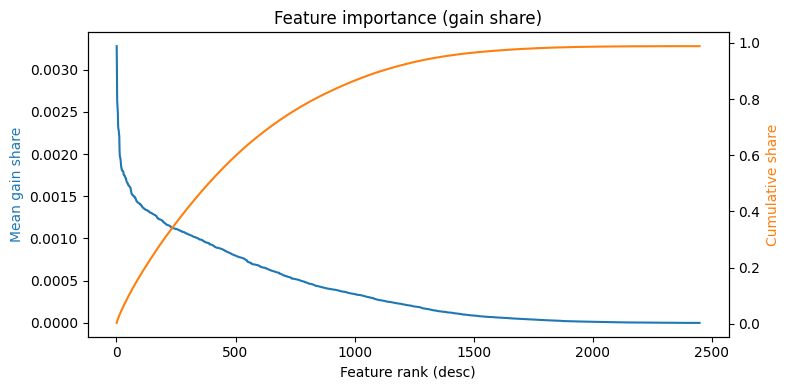

In [28]:
dfi = fi_normal[["feature", "mean_gain_share"]].copy()
dfi.reset_index(drop=True, inplace=True)
dfi['rank'] = dfi.index + 1

cum_share = dfi["mean_gain_share"].cumsum()

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(dfi["rank"], dfi["mean_gain_share"], color="tab:blue")
ax1.set_xlabel("Feature rank (desc)")
ax1.set_ylabel("Mean gain share", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(dfi["rank"], cum_share, color="tab:orange")
ax2.set_ylabel("Cumulative share", color="tab:orange")

plt.title("Feature importance (gain share)")
plt.tight_layout()
plt.show()


In [29]:
cum_share = dfi["mean_gain_share"].cumsum()
tot = cum_share.iloc[-1]
for th in [0.8, 0.9, 0.95]:
    k = (cum_share <= th*tot).sum()
    print(f"{th*100:.0f}% → Top-{k}")


80% → Top-811
90% → Top-1074
95% → Top-1287


In [33]:
whitelist

['time_pos',
 'time_sin',
 'time_cos',
 'time_bucket_6',
 'is_open_auction',
 'is_close_auction']

In [30]:
final_feats = list(dict.fromkeys(whitelist + dfi['feature'][:800].tolist()))  # 保持顺序且不重复
final_feats = pd.Series(final_feats)

final_feats.to_csv("/mnt/data/js/exp/v1/sample_mm/top_fi_0910.csv", index=False, header=False)

In [31]:
final_feats

0                time_pos
1                time_sin
2                time_cos
3           time_bucket_6
4         is_open_auction
              ...        
801    feature_28__lag100
802    feature_23__ewm968
803    feature_78__ewm256
804            feature_56
805    feature_42__lag968
Length: 806, dtype: object

# 去共线性

In [ ]:
PARQUET_PATHS = ["/mnt/data/js/final_clean.parquet"]
KEYS = ["symbol_id","date_id","time_id"]
TARGET = "responder_6"
FEATURE_COLS = pd.read_csv('/home/admin_ml/Jackson/projects/selected_features.csv')['family'].tolist()
REP_COLS = pd.read_csv('/home/admin_ml/Jackson/projects/selected_resps.csv')['family'].tolist()

lf_base = pl.scan_parquet(PARQUET_PATHS).select(KEYS+FEATURE_COLS+REP_COLS)


lf_slice = lf_base.filter((pl.col("date_id") >= 1200) & (pl.col("date_id") <= 1400))

PARAMS = dict(
        prev_soft_days=7,
        tail_lags=(2, 5, 20, 40, 100),
        tail_diffs=(2, 5,),
        rolling_windows=(5, 20),
        same_time_ndays=5,
        strict_k=False,
        hist_lags=(1,2,5,10,20,100),
        ret_periods=(1,5,20),
        diff_periods=(1,5),
        rz_windows=(5,20),
        ewm_spans=(5,40,100),
        cs_cols=None,       # <- keep this small to avoid blow-up
    )

lf_eng = run_engineering_on_slice(lf_slice, **PARAMS)

feats = pd.read_csv("/home/admin_ml/Jackson/projects/final_fi_mean.csv")["feature"].tolist()

lf_small = lf_eng.select(feats[:500])
lf_small.collect(streaming=True).write_parquet("/mnt/data/js/X_ready.parquet", compression="zstd")


In [ ]:

lf = pl.scan_parquet("/mnt/data/js/X_ready.parquet")

df = lf.collect(streaming=True).to_pandas()

# Correlation (pairwise complete obs) + guard on min observations
min_obs = max(50, int(0.3 * len(df)))  # tweak as you like
C = df.corr(method="pearson", min_periods=min_obs).abs().fillna(0.0)

# Ensure to align rows & cols to the same (priority) order, fill any NaNs with 0
order = feats
C = C.reindex(index=order, columns=order).fillna(0.0).copy()


# --- Prepare NumPy array for the greedy loop ---
A = C.values
np.fill_diagonal(A, 0.0)  # ensure the value is smaller than thresh, so the feature won't be dropped by value'1'
m = len(order)

# --- Greedy de-correlation (keep-by-priority, drop neighbors) ---
THRESH = 0.97
keep_mask = np.ones(m, dtype=bool)

for i in range(m):
    if not keep_mask[i]:
        continue  # already removed by a higher-priority pick
    # only check j > i (upper triangle) among still-active features
    active_slice = keep_mask[i+1:]
    drop = (A[i, i+1:] >= THRESH) & active_slice
    active_slice[drop] = False  # marks into keep_mask[i+1:] via view
keep = [order[i] for i in range(m) if keep_mask[i]]


pd.DataFrame({'feature': keep}).to_csv("final_selected_features.csv", index=False)

# 全数据训练

基本配置

In [ ]:
DATE_LO, DATE_HI = 680, 1530 # 指定训练/验证的 date_id 范围, 后期转为全部训练集
# 基本量
FEATURE_COLS = [f"feature_{i:02d}" for i in range(79)] #FEATURE_COLS = pd.read_csv(f"{INPUT_DIR}/selected_features_1r.csv", header=None).squeeze().tolist()
REP_COLS = [f"responder_{i}" for i in range(9)] #REP_COLS = pd.read_csv(f"{INPUT_DIR}/selected_responders_1r.csv", header=None).squeeze().tolist()

paths = fs.glob(f"{P('az', 'exp/v1', cfg['paths']['clean'])}/*.parquet")
clean_files = []
for p in paths:
    bn = os.path.basename(p)
    parts = bn.split('_')
    start = int(parts[1])
    clean_files.append((start, p))
    
clean_sorted_file_list = [f"az://{f}" for _, f in sorted(clean_files)]

lc = pl.scan_parquet(clean_sorted_file_list, storage_options=storage_options)


print("ready")

枚举窗口

In [ ]:
# 从 Blob 列出全部 fe_shards 分片（返回不带协议的路径，要手动加 az://）

fe_all = fs.glob(f"{P('np', 'exp/v1',cfg['paths']['fe_shards'])}/*.parquet")
fe_all = [f"az://{p}" for p in fe_all]

# 按日期范围筛选
wins = set()
for p in fe_all:
    base = p.split("/")[-1]  # e.g. C_lags_1220_1249.parquet
    lo = int(base.split("_")[-2]); hi = int(base.split("_")[-1].split(".")[0])
    if hi >= DATE_LO and lo <= DATE_HI:
        wins.add((lo, hi))
wins = sorted(wins)
print(f"windows in range: {wins[:5]} ... (total {len(wins)})")

# 取得该区间实际天
days = [d for d in range(DATE_LO, DATE_HI+1)]
#cut = int(len(days)*0.8)


3. 按窗口拼接 (A + B + 所有 C_*) → 直接写数据分片（无大表）

In [ ]:
import numpy as np
import polars as pl
import gc

T = int(cfg['ticks'])                 # 例如 968 
K = int(cfg['bucket_size'])           # 例如 6
open_n  = int(cfg.get('open_auction_ticks', 5))
close_n = int(cfg.get('close_auction_ticks', 5))

# 安全的“上界截断”工具（兼容旧版 Polars 无 clip_max）
def clip_upper(expr: pl.Expr, ub: int) -> pl.Expr:
    return pl.when(expr > pl.lit(ub)).then(pl.lit(ub)).otherwise(expr)

for (lo, hi) in wins:
    # 与全局区间取交集，防止边缘窗口越界
    w_lo, w_hi = max(lo, DATE_LO), min(hi, DATE_HI)

    # 基表（先筛行，再一次性加时间特征）
    base = (
        lc.filter(pl.col("date_id").is_between(w_lo, w_hi))
          .select([*cfg['keys'], cfg['target'], cfg['weight'], *FEATURE_COLS])
        .with_columns([
            # 复制一份 time_id 作为“位置特征”，避免与 key 列冲突
            pl.col("time_id").cast(pl.Float32).alias("time_pos"),

              # 周期相位：phase = 2π * time_id / T
              (2*np.pi * pl.col("time_id") / pl.lit(T, dtype=pl.Float32)).alias("_phase_"),
        ])
        .with_columns([
            # 兼容旧版：对表达式调用 .sin() / .cos()
            pl.col("_phase_").sin().cast(pl.Float32).alias("time_sin"),
            pl.col("_phase_").cos().cast(pl.Float32).alias("time_cos"),
        ])
        .drop(["_phase_"])
        .with_columns([
            # 开盘/收盘指示器（恰好 open_n / close_n 个 tick）
            (pl.col("time_id") <  pl.lit(open_n)).cast(pl.Int8).alias("is_open_auction"),
            (pl.col("time_id") >= pl.lit(T - close_n)).cast(pl.Int8).alias("is_close_auction"),
        ])
    )

    # 分桶：bucket = floor(time_id * K / T)，并防御性截到 [0..K-1]
    bucket_raw = ( (pl.col('time_id') * pl.lit(K)) // pl.lit(T) )
    bucket_capped = clip_upper(bucket_raw, K - 1)
    base = base.with_columns([
        bucket_capped.cast(pl.Int8).alias(f"time_bucket_{K}")
    ])

    lf = base  # 后面继续你的 join 逻辑

    fe_files = []
    for name in (f"A_{lo}_{hi}.parquet", f"B_{lo}_{hi}.parquet"):
        p = f"{P('az', 'exp/v1', cfg['paths']['fe_shards'])}/{name}"
        fe_files.append(p)

    # 同窗口所有 C_* 分片
    c_files = fs.glob(f"{P('np', 'exp/v1', cfg['paths']['fe_shards'])}/C_*_{lo}_{hi}.parquet")
    c_files = [f"az://{p}" for p in c_files]
    fe_files.extend(c_files)

    # 逐个左连接
    already = set(lf.collect_schema().names())
    for fp in fe_files:
        ds = pl.scan_parquet(fp, storage_options=storage_options)
        names = ds.collect_schema().names()
        add_cols = [c for c in names if c not in already]
        if add_cols:
            lf = lf.join(ds.select([*cfg['keys'], *add_cols]), on=cfg['keys'], how="left")
            already.update(add_cols)

    # 选出特征并统一类型
    feat_present = [c for c in already if c not in (*cfg['keys'], cfg['target'], cfg['weight'])]
    select_exprs = [
        *cfg['keys'],
        pl.col(cfg['target']).cast(pl.Float32).alias(cfg['target']),
        pl.col(cfg['weight']).cast(pl.Float32).alias(cfg['weight']),
        *[pl.col(c).cast(pl.Float32).alias(c) for c in feat_present],
    ]
    lf_win = lf.select(select_exprs)

    # 直接流式写分片
    panel_path = P("az", "exp/v1", cfg["paths"]["panel_shards"])
    fs.mkdir(panel_path, exist_ok=True)
    out_path = f"{panel_path}/panel_{w_lo}_{w_hi}.parquet"
    (
        lf_win.sink_parquet(
            out_path,
            compression="zstd",
            storage_options=storage_options,
            statistics=True,
            maintain_order=True,
        )
    )

    gc.collect()


4.导入最终特征清单

In [ ]:

feat_cols = pd.read_csv("/mnt/data/js/exp/v1/sample_mm//fe_v1_gain_share.csv")["feature"].tolist()
feat_cols[:10]


In [ ]:
len(feat_cols)

5.构建memmap

In [ ]:
import re
mm_dir = P("local", "exp/v1", cfg["paths"]["panel_mm"])
os.makedirs(mm_dir, exist_ok=True)

def full_shard_key(p: str):
    bn = os.path.basename(p)          # e.g. panel_1200_1219.parquet
    m = re.match(r"panel_(\d+)_(\d+)\.parquet$", bn)
    if not m:
        return (10**12, 10**12, bn)
    lo, hi = map(int, m.groups())
    return (lo, hi)


def shard2memmap(glob_paths: list[str], feat_cols: list[str], prefix: str):
    date_col   = cfg["keys"][1]
    target_col = cfg["target"]
    weight_col = cfg["weight"]

    paths = sorted(glob_paths, key=full_shard_key)

    counts = []
    for p in paths:
        k = (pl.scan_parquet(p, storage_options=storage_options)
               .select(pl.len()).collect(streaming=True).item())
        counts.append(int(k))
    n_rows, n_feat = int(sum(counts)), len(feat_cols)

    os.makedirs(os.path.dirname(prefix), exist_ok=True)

    X = np.memmap(f"{prefix}_X.float32.mmap", dtype="float32", mode="w+", shape=(n_rows, n_feat))
    y = np.memmap(f"{prefix}_y.float32.mmap", dtype="float32", mode="w+", shape=(n_rows,))
    w = np.memmap(f"{prefix}_w.float32.mmap", dtype="float32", mode="w+", shape=(n_rows,))
    d = np.memmap(f"{prefix}.date.i32.mmap",  dtype="int32",   mode="w+", shape=(n_rows,))

    i = 0
    need_cols = [date_col, target_col, weight_col, *feat_cols]
    for p, k in zip(paths, counts):
        df = (pl.scan_parquet(p, storage_options=storage_options)
                .select(need_cols).collect(streaming=True))

        X[i:i+k, :] = df.select(feat_cols).to_numpy()
        y[i:i+k]    = df.select(pl.col(target_col)).to_numpy().ravel()
        w[i:i+k]    = df.select(pl.col(weight_col)).to_numpy().ravel()
        d[i:i+k]    = df.select(pl.col(date_col)).to_numpy().ravel().astype("int32")
        i += k
        del df; gc.collect()

    X.flush(); y.flush(); w.flush(); d.flush()

    meta = {
        "n_rows": int(n_rows), "n_feat": int(n_feat), "dtype": "float32", "ts": time.time(),
        "features": list(feat_cols), "target": target_col, "weight": weight_col,
        "date_col": date_col, "files": paths
    }
    with open(f"{prefix}.meta.json", "w") as f:
        json.dump(meta, f)
    return X, y, w

In [ ]:
np_paths = fs.glob(f"{P('np', 'exp/v1', cfg['paths']['panel_shards'])}/panel_*_*.parquet")
glob_paths = []
for p in np_paths:
    glob_paths.append(f"az://{p}")
    
X, y, w = shard2memmap(glob_paths= glob_paths, feat_cols=feat_cols, prefix=f"{mm_dir}/full_panel_v1")


In [ ]:
# 滑动式来分割训练集/验证集

d = np.memmap(f"/mnt/data/js/exp/v1/panel_mm/full_panel_v1.date.i32.mmap", dtype="int32", mode="r")

def make_sliding_cv(days:List, *, n_splits: int, gap_days: int = 5, train_to_val: int = 9):
    """
    滑动式 walk-forward（固定 train:val = R:1，步长 = 当前折的验证长度 V_i）。
    给定折数 K、gap G、比例 R:
        (R + K) * V = N - G
    其中 N 为 unique(date_id) 的天数。
    做法：
      1) V_base = floor((N - G) / (R + K))，余数 rem 均匀分配到前 rem 个验证窗口（各 +1）。
      2) 训练窗口长度 T = R * V_base（固定）。
      3) 第 1 折验证起点 v_lo = T + G；每折验证长度依次为 v_lens[i]，下一折起点递增 v_lo += V_i。
      4) 每折：
            train_days = days[tr_lo:tr_hi]，其中 tr_hi = v_lo - G，tr_lo = tr_hi - T
            valid_days = days[v_lo:v_hi]，其中 v_hi = v_lo + V_i
    返回：folds = [(train_idx, val_idx), ...]；若不可行返回 []。
    """
    # 读取并排序唯一日期
    N = len(days)
    R = int(train_to_val)
    K = int(n_splits)
    usable = N - int(gap_days)
    if usable <= 0 or K <= 0 or R <= 0:
        return []

    # 基准验证窗口与余数
    V_base, rem = divmod(usable, R + K)
    if V_base <= 0:
        return []

    # 固定训练窗口；验证窗口长度列表（前 rem 折 +1 天）
    T = R * V_base
    v_lens = [V_base + 1 if i < rem else V_base for i in range(K)]

    # 第一折验证起点
    v_lo = T + gap_days
    folds = []

    for V_i in v_lens:
        v_hi  = v_lo + V_i
        tr_hi = v_lo - gap_days
        tr_lo = tr_hi - T

        # 边界不可行就停止
        if tr_lo < 0 or v_hi > N:
            break

        # 映射到样本行索引
        tr_days = days[tr_lo:tr_hi]
        va_days = days[v_lo:v_hi]
        tr_idx  = np.flatnonzero(np.isin(d, tr_days))
        va_idx  = np.flatnonzero(np.isin(d, va_days))
        if len(tr_idx) == 0 or len(va_idx) == 0:
            break

        folds.append((tr_idx, va_idx))
        v_lo = v_hi  # 下一折从这里开始

    return folds

folds = make_sliding_cv(days=d, n_splits=3, gap_days=5, train_to_val=9)


In [ ]:
# ---------- 2) 加载 memmap ----------
import json, numpy as np, lightgbm as lgb
prefix = f"/mnt/data/js/exp/v1/panel_mm/full_panel_v1"
with open(f"{prefix}.meta.json") as f:
    meta = json.load(f)
n_rows, n_feat = meta["n_rows"], meta["n_feat"]
feat_names = meta["features"]

X = np.memmap(f"{prefix}_X.float32.mmap", dtype="float32", mode="r", shape=(n_rows, n_feat))
y = np.memmap(f"{prefix}_y.float32.mmap", dtype="float32", mode="r", shape=(n_rows,))
w = np.memmap(f"{prefix}_w.float32.mmap", dtype="float32", mode="r", shape=(n_rows,))
# 你之前已定义：weighted_r2_zero_mean、lgb_wr2_eval


训练

In [ ]:
# 1) 统计 200 天窗口的行数（按你真实筛选逻辑来）
n_rows = (
    lc.filter(pl.col("date_id").is_between(DATE_LO, DATE_HI))  # 你选的 200天区间
      .select(pl.len())
      .collect()
      .item()  # -> int
)

#  估算 GPU “transfer to GPU” 的大头（经验值）
n_feat = len(feat_names)
dense_groups = int(n_feat)  # 按之前比例估
bytes_est = n_rows * 0.8* dense_groups         
gb_est = bytes_est / (1024**3)

print(f"rows≈{n_rows:,}, dense_groups≈{dense_groups}, est GPU load≈{gb_est:.2f} GiB")


In [ ]:
DATE_LO, DATE_HI = 680, 1529 # 指定训练/验证的 date_id 范围, 后期转为全部训练集

BASE_PATH = f"{BASE_DIR}/final_clean.parquet"

# 从 Blob 列出全部 fe_shards 分片（返回不带协议的路径，要手动加 az://）
fe_all = fs.glob(f"{FE_SHA_DIR_B}/*_*.parquet")
fe_all = [p if p.startswith("az://") else f"az://{p}" for p in fe_all]

# 按日期范围筛选
wins = set()
for p in fe_all:
    base = p.split("/")[-1]  # e.g. C_lags_1220_1249.parquet
    lo = int(base.split("_")[-2]); hi = int(base.split("_")[-1].split(".")[0])
    if hi >= DATE_LO and lo <= DATE_HI:
        wins.add((lo, hi))
wins = sorted(wins)
print(f"windows in range: {wins[:5]} ... (total {len(wins)})")


# 取得该区间实际天，并按 80/20 切分（天为单位，避免泄露）
days = (pl.scan_parquet(BASE_PATH, storage_options=storage_options)
        .filter(pl.col("date_id").is_between(DATE_LO, DATE_HI))
        .select(pl.col("date_id").unique().sort())
        .collect(streaming=True)["date_id"].to_list())
assert days, "no days found in range"
cut = int(len(days)*0.8)
train_days, val_days = set(days[:cut]), set(days[cut:])
print(f"days total={len(days)}  train={len(train_days)}  val={len(val_days)}")



for (lo, hi) in wins:
    # 与全局区间取交集，防止边缘窗口越界
    w_lo, w_hi = max(lo, DATE_LO), min(hi, DATE_HI)

    # 基表 (带 TARGET/WEIGHT + 基础特征)
    lf = (pl.scan_parquet(BASE_PATH, storage_options=storage_options)
            .filter(pl.col("date_id").is_between(w_lo, w_hi))
            .select([*KEYS, TARGET, WEIGHT, *[pl.col(c) for c in FEATURE_COLS]]))

    protocol = FE_SHA_DIR_B.split("://", 1)[0] + "://"

    # 若 fe_all 可能是无协议，先归一化
    fe_set = {p if p.startswith(protocol) else protocol + p for p in fe_all}

    fe_files = []
    for name in (f"A_{lo}_{hi}.parquet", f"B_{lo}_{hi}.parquet"):
        p = f"{FE_SHA_DIR_B}/{name}"  # 带协议
        if p in fe_set:
            fe_files.append(p)

    # 同窗口所有 C_* 分片
    c_files = fs.glob(f"{FE_SHA_DIR_NP}/C_*_{lo}_{hi}.parquet")  # 无协议
    fe_files += [p if p.startswith(protocol) else protocol + p for p in sorted(c_files)]


    # 逐个左连接（scan 到 Blob 时一定加 storage_options）
    already = set(lf.collect_schema().names())
    for fp in fe_files:
        ds = pl.scan_parquet(fp, storage_options=storage_options)
        names = ds.collect_schema().names()
        add_cols = [c for c in names if c not in already]
        if add_cols:
            lf = lf.join(ds.select([*KEYS, *add_cols]), on=KEYS, how="left")
            already.update(add_cols)


    # 统一 float32；注意：此窗口缺失的特征列**不写入**→ 之后 memmap 会自动补 None
    feat_present = [c for c in already if c not in (*KEYS, TARGET, WEIGHT)]
    select_exprs = [
        *KEYS,
        pl.col(TARGET).cast(pl.Float32).alias(TARGET),
        pl.col(WEIGHT).cast(pl.Float32).alias(WEIGHT),
        *[pl.col(c).cast(pl.Float32).alias(c) for c in feat_present],
    ]
    lf_win = lf.select(select_exprs)

    # 直接流式写 train/val 分片（不 materialize 整个窗口）
    out_train = f"{FE_SHA_DIR_B}/train_{lo}_{hi}.parquet"
    out_val   = f"{FE_SHA_DIR_B}/val_{lo}_{hi}.parquet"
    (lf_win.filter(pl.col("date_id").is_in(list(train_days)))
           .sink_parquet(out_train, compression="zstd", storage_options=storage_options))
    (lf_win.filter(pl.col("date_id").is_in(list(val_days)))
           .sink_parquet(out_val, compression="zstd", storage_options=storage_options))

    print(f"[{lo}_{hi}] write: {os.path.basename(out_train)}, {os.path.basename(out_val)}")
    gc.collect()


In [ ]:
import json, time

feat_cols = pd.read_csv('exp/v1/config/input_sets/top_imp.csv')
feat_cols = feat_cols['feature'].tolist()

feat_cols = [*feat_cols, 'time_id']      # 或 feat_cols + ['time_id']
# Check the length of feature columns
print(len(feat_cols))

In [ ]:

def shard2memmap(glob_pat, feat_cols, prefix, fs=None, storage_options=None,
                 target_col=TARGET, weight_col=WEIGHT):
    """
    将若干 parquet 分片顺序拼接为三份 memmap: X(float32), y(float32), w(float32)
    - 支持本地路径和 az:// 路径（自动选择 glob 方式）
    - 缺失的特征列用 None (=> NaN) 补齐，列顺序以 feat_cols 为准
    - 会在同目录写出 {prefix}_{X,y,w}.float32.mmap 以及 {prefix}.meta.json
    """

    def _is_az(p: str) -> bool:
        return isinstance(p, str) and p.startswith("az://")

    def _glob_paths(pattern: str):
        # 远程：用 fsspec.filesystem("az").glob(无协议) → 再补上 az://
        if _is_az(pattern):
            assert fs is not None, "fs must be provided for az:// glob"
            nopro = pattern[len("az://"):]               # 去协议
            listed = fs.glob(nopro)                       # 无协议
            return ["az://" + p for p in sorted(listed)]  # 归一化为带协议
        else:
            import glob as _glob
            return sorted(_glob.glob(pattern))            # 本地

    def _scan(p: str):
        if _is_az(p):
            return pl.scan_parquet(p, storage_options=storage_options)
        else:
            return pl.scan_parquet(p)

    # 1) 列出分片
    paths = _glob_paths(glob_pat)
    if not paths:
        raise FileNotFoundError(f"No shards matched: {glob_pat}")

    # 2) 统计每个分片的行数（流式）
    counts = []
    for p in paths:
        k = _scan(p).select(pl.len()).collect(streaming=True).item()
        counts.append(int(k))

    n_rows, n_feat = int(sum(counts)), len(feat_cols)
    print(f"[memmap] {glob_pat}: {len(paths)} files, {n_rows} rows, {n_feat} features")

    # 3) 分配 memmap（本地）
    X = np.memmap(f"{prefix}_X.float32.mmap", dtype="float32", mode="w+", shape=(n_rows, n_feat))
    y = np.memmap(f"{prefix}_y.float32.mmap", dtype="float32", mode="w+", shape=(n_rows,))
    w = np.memmap(f"{prefix}_w.float32.mmap", dtype="float32", mode="w+", shape=(n_rows,))

    # 4) 逐分片流式写入
    i = 0
    for p, k in zip(paths, counts):
        lf = _scan(p)
        names = set(lf.collect_schema().names())
        exprs = [
            (pl.col(c).cast(pl.Float32).alias(c) if c in names
             else pl.lit(None, dtype=pl.Float32).alias(c))
            for c in feat_cols
        ]
        df = (lf.select([
                pl.col(target_col).cast(pl.Float32).alias(target_col),
                pl.col(weight_col).cast(pl.Float32).alias(weight_col),
                *exprs
             ])
             .collect(streaming=True))

        X[i:i+k, :] = df.select(feat_cols).to_numpy()
        y[i:i+k]    = df.select(pl.col(target_col)).to_numpy().ravel()
        w[i:i+k]    = df.select(pl.col(weight_col)).to_numpy().ravel()
        i += k
        del df; gc.collect()

    X.flush(); y.flush(); w.flush()

    # 5) 保存 meta
    meta = {"n_rows": int(n_rows), "n_feat": int(n_feat), "dtype": "float32", "ts": time.time(),
            "features": list(feat_cols), "target": target_col, "weight": weight_col}
    with open(f"{prefix}.meta.json", "w") as f:
        json.dump(meta, f)

    return X, y, w


train_X, train_y, train_w = shard2memmap(
    f"{FE_SHA_DIR_B}/train_*.parquet", feat_cols, f"{MM_DIR}/train",
    fs=fs, storage_options=storage_options)

val_X,   val_y,   val_w   = shard2memmap(
    f"{FE_SHA_DIR_B}/val_*.parquet",   feat_cols, f"{MM_DIR}/val",
    fs=fs, storage_options=storage_options)

print("train shapes:", train_X.shape, train_y.shape, train_w.shape)
print("val   shapes:", val_X.shape,   val_y.shape,   val_w.shape)


In [ ]:
import os, json, numpy as np

def load_memmap(prefix, readonly=True):
    meta_path = f"{prefix}.meta.json"
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"missing {meta_path}")
    with open(meta_path, "r") as f:
        meta = json.load(f)
    dtype = np.dtype(meta.get("dtype", "float32"))
    n_rows, n_feat = int(meta["n_rows"]), int(meta["n_feat"])
    mode = "r" if readonly else "r+"

    X = np.memmap(f"{prefix}_X.float32.mmap", dtype=dtype, mode=mode, shape=(n_rows, n_feat))
    y = np.memmap(f"{prefix}_y.float32.mmap", dtype=dtype, mode=mode, shape=(n_rows,))
    w = np.memmap(f"{prefix}_w.float32.mmap", dtype=dtype, mode=mode, shape=(n_rows,))
    feat_cols = meta.get("features")  # 用保存的列顺序，避免不一致
    return X, y, w, feat_cols, meta

def ensure_memmap(prefix, glob_pat, feat_cols, *, fs=None, storage_options=None,
                  target_col="responder_6", weight_col="weight"):
    try:
        return load_memmap(prefix)
    except FileNotFoundError:
        X, y, w = shard2memmap(glob_pat, feat_cols, prefix, fs=fs, storage_options=storage_options,
                               target_col=target_col, weight_col=weight_col)
        # 重新加载一次，拿回 meta 和规范的 feat_cols
        return load_memmap(prefix)

# —— 使用：
train_X, train_y, train_w, feat_cols, _ = ensure_memmap(
    f"{MM_DIR}/train", f"{FE_SHA_DIR_B}/train_*.parquet", feat_cols,
    fs=fs, storage_options=storage_options)

val_X, val_y, val_w, _, _ = ensure_memmap(
    f"{MM_DIR}/val", f"{FE_SHA_DIR_B}/val_*.parquet", feat_cols,
    fs=fs, storage_options=storage_options)




def weighted_r2_zero_mean(y_true, y_pred, weight):
    y_true = np.asarray(y_true, dtype=np.float64).ravel()
    y_pred = np.asarray(y_pred, dtype=np.float64).ravel()
    weight = np.asarray(weight, dtype=np.float64).ravel()
    num = np.sum(weight * (y_true - y_pred)**2)
    den = np.sum(weight * (y_true**2))
    return 0.0 if den <= 0 else 1.0 - (num/den)

def lgb_wr2_eval(preds, train_data):
    y = train_data.get_label()
    w = train_data.get_weight()
    if w is None:
        w = np.ones_like(y)
    return ("wr2", weighted_r2_zero_mean(y, preds, w), True)

dtrain = lgb.Dataset(train_X, label=train_y, weight=train_w, feature_name=feat_cols, free_raw_data=True)
dval   = lgb.Dataset(val_X,   label=val_y,   weight=val_w,   feature_name=feat_cols, reference=dtrain, free_raw_data=True)

params = dict(
    objective="regression",
    metric="None",
    learning_rate=0.03,              # ↓ 更小学习率，配合更多轮数
    num_leaves=127,                  # ↑ 增强模型容量
    max_depth=10,
    min_data_in_leaf=200,            # ↑ 稳定、抑制过拟合
    num_threads=16,
    seed=42,
    deterministic=True,
    first_metric_only=True,

    # 直方图/分箱（GPU 友好）
    max_bin=63,
    bin_construct_sample_cnt=400_000,# ↑ 分箱更准（全量训练）
    min_data_in_bin=3,

    # GPU
    device_type="gpu",
    gpu_device_id=0,

    # 采样 + 正则
    feature_fraction=0.65,           # 列采样
    feature_fraction_bynode=0.8,     # 结点级列采样
    bagging_fraction=0.70,           # 行采样
    bagging_freq=1,
    lambda_l2=5.0,                   # L2 正则更稳
    extra_trees=True,                # 更稳更快（常见于大数据）
)

model = lgb.train(
    params, dtrain,
    valid_sets=[dval], valid_names=["val"],   # 只监控验证集，收敛更快
    num_boost_round=4000,                     # ↑ 配合小 lr
    callbacks=[lgb.early_stopping(200), lgb.log_evaluation(50)],
    feval=lgb_wr2_eval,
)


imp = pd.DataFrame({
    "feature": model.feature_name(),
    "gain": model.feature_importance("gain"),
    "split": model.feature_importance("split"),
}).sort_values("gain", ascending=False).reset_index(drop=True)

print(imp.head(30))


In [ ]:
# 如果不存在则创建目录
os.makedirs("exp/v1/models", exist_ok=True)

# save model
model.save_model("exp/v1/models/lgbm_tv_model.txt")

In [ ]:
# 合并验证集和训练集，重新训练最终模型

In [ ]:
imp.tail()

# 模型评估

首先对测试集做特征工程

In [ ]:
# ====== 参数（与训练期基本一致，仅改为 test 路径/前缀） ======
import os, gc
import polars as pl

DATE_LO, DATE_HI = 1530, 1698  # 可按需调整或覆盖

# 从 Blob 列出全部 test fe_shards 分片（无协议 → 统一加协议）
fe_all_np = fs.glob(f"{FE_SHA_DIR_NP}/test_*_*.parquet")
protocol = FE_SHA_DIR_B.split("://", 1)[0] + "://"
fe_all = [p if p.startswith(protocol) else protocol + p for p in fe_all_np]

# ---- 解析所有窗口，并按日期范围筛选（与训练期相同逻辑）----
wins = set()
for p in fe_all_np:
    base = os.path.basename(p)                         # e.g. test_C_lags_1220_1249.parquet
    stem = base[:-8]                                   # 去掉 .parquet
    parts = stem.split("_")
    lo, hi = int(parts[-2]), int(parts[-1])            # 最后两段是 lo/hi
    if hi >= DATE_LO and lo <= DATE_HI:
        wins.add((lo, hi))
wins = sorted(wins)
print(f"windows in range: {wins[:5]} ... (total {len(wins)})")

# ---- 获取该区间内实际存在的 date_id（仅用于 sanity/log；不做 train/val 切分）----
days = (pl.scan_parquet(TEST_BASE_PATH, storage_options=storage_options)
          .filter(pl.col("date_id").is_between(DATE_LO, DATE_HI))
          .select(pl.col("date_id").unique().sort())
          .collect(streaming=True)["date_id"].to_list())
assert days, "no days found in range"
print(f"days total={len(days)}")

# ---- 主循环：对每个 (lo,hi) 窗口横向拼接后，写出 test_{lo}_{hi}.parquet ----
for (lo, hi) in wins:
    # 与全局区间取交集，防止边缘窗口越界
    w_lo, w_hi = max(lo, DATE_LO), min(hi, DATE_HI)

    # 基表（仅 KEYS + 可选 WEIGHT + 基础特征），并固定排序保证因果/可复现
    # 注意：WEIGHT 在 test 里可能不存在，做个存在性判断
    base_scan = (pl.scan_parquet(TEST_BASE_PATH, storage_options=storage_options)
                   .filter(pl.col("date_id").is_between(w_lo, w_hi))
                   .sort(KEYS))

    lf = base_scan.select([*KEYS, WEIGHT, *[pl.col(c) for c in FEATURE_COLS]])

    # 归一化分片路径集合，方便存在性判断
    fe_set = {p if p.startswith(protocol) else protocol + p for p in fe_all_np}

    # A/B 文件（test_ 前缀）
    fe_files = []
    for name in (f"test_A_{lo}_{hi}.parquet", f"test_B_{lo}_{hi}.parquet"):
        p = f"{FE_SHA_DIR_B}/{name}"  # 带协议
        if p in fe_set or fs.exists(p):
            fe_files.append(p)

    # 同窗口所有 C_* 分片（无协议 → 加协议）
    c_files_np = fs.glob(f"{FE_SHA_DIR_NP}/test_C_*_{lo}_{hi}.parquet")
    fe_files += [p if p.startswith(protocol) else protocol + p for p in sorted(c_files_np)]

    # 逐个左连接（严格只补充新列，避免重复；scan 到 Blob 时加 storage_options）
    already = set(lf.collect_schema().names())
    for fp in fe_files:
        ds = pl.scan_parquet(fp, storage_options=storage_options)
        names = ds.collect_schema().names()
        add_cols = [c for c in names if c not in already]
        if add_cols:
            lf = lf.join(ds.select([*KEYS, *add_cols]), on=KEYS, how="left")
            already.update(add_cols)

    # 统一为 Float32；test 无 TARGET，所以只保留 KEYS + 可选 WEIGHT + 所有特征
    keep_non_key = [c for c in already if c not in set(KEYS)]
    # 确保 WEIGHT 不在特征转换列表里被重复处理
    feat_present = [c for c in keep_non_key if c not in (*KEYS, WEIGHT)]

    select_exprs = [
        *KEYS, 
        pl.col(WEIGHT).cast(pl.Float32).alias(WEIGHT), 
        *[pl.col(c).cast(pl.Float32).alias(c) for c in feat_present], ]
    lf_win = lf.select(select_exprs)

    # 写出单文件 test_{lo}_{hi}.parquet（流式，不 materialize 全窗口）
    out_test = f"{FE_SHA_DIR_B}/test_{lo}_{hi}.parquet"
    # 覆盖旧文件（若存在）
    if fs.exists(out_test):
        fs.rm(out_test)

    lf_win.sink_parquet(
        out_test,
        compression="zstd",
        statistics=True,
        storage_options=storage_options,
        maintain_order=True,  # 上面已 sort(KEYS)，这里维持写出顺序
    )

    print(f"[{lo}_{hi}] write: {os.path.basename(out_test)}  (cols={len(select_exprs)})")
    gc.collect()


In [ ]:
import os, gc, json, time, re
import numpy as np
import polars as pl
import pandas as pd

feat_cols = pd.read_csv('exp/v1/config/input_sets/top_imp.csv')['feature'].tolist()
feat_cols = [*feat_cols, 'time_id']      # 或 feat_cols + ['time_id']

def shard2memmap(fe_paths, feat_cols, prefix, storage_options=None):
    """
    将若干 parquet 分片顺序拼接为一份 memmap: X(float32)
    - 仅提取 feat_cols（缺失列用 NaN 补齐），列顺序以 feat_cols 为准
    - 输出：{prefix}_X.float32.mmap 与 {prefix}.meta.json
    - fe_paths: 已经挑选/过滤好的最终 test_{lo}_{hi}.parquet 列表（可含 az:// 或本地路径）
    """

    # 0) 规范化 + 数值排序
    def _numeric_key(p: str):
        b = os.path.basename(p)
        stem = b[:-8]  # 去掉 .parquet
        parts = stem.split("_")
        try:
            lo, hi = int(parts[-2]), int(parts[-1])
            return (lo, hi)
        except Exception:
            return (b, b)
    fe_paths = sorted(fe_paths, key=_numeric_key)

    # 1) 兜底：确保有文件、确保输出目录存在
    if not fe_paths:
        raise FileNotFoundError("fe_paths is empty.")
    os.makedirs(os.path.dirname(prefix), exist_ok=True)

    # 2) 统计每个分片的行数（流式）
    counts = []
    for p in fe_paths:
        lf = (pl.scan_parquet(p, storage_options=storage_options)
              if p.startswith("az://") else pl.scan_parquet(p))
        k = lf.select(pl.len()).collect(streaming=True).item()
        counts.append(int(k))
    n_rows, n_feat = int(sum(counts)), len(feat_cols)
    print(f"[memmap]: {len(fe_paths)} files, {n_rows} rows, {n_feat} features")

    # 3) 分配 memmap（本地）
    X = np.memmap(f"{prefix}_X.float32.mmap", dtype="float32", mode="w+", shape=(n_rows, n_feat))

    # 4) 逐分片流式写入
    i = 0
    for p, k in zip(fe_paths, counts):
        lf = (pl.scan_parquet(p, storage_options=storage_options)
              if p.startswith("az://") else pl.scan_parquet(p))
        names = set(lf.collect_schema().names())
        exprs = [
            (pl.col(c).cast(pl.Float32).alias(c) if c in names
             else pl.lit(None, dtype=pl.Float32).alias(c))
            for c in feat_cols
        ]
        df = lf.select(exprs).collect(streaming=True)

        X[i:i+k, :] = df.select(feat_cols).to_numpy()
        i += k
        del df; gc.collect()

    X.flush()

    # 5) 保存 meta（含来源文件）
    meta = {
        "n_rows": int(n_rows),
        "n_feat": int(n_feat),
        "dtype": "float32",
        "ts": time.time(),
        "features": list(feat_cols),
        "paths": list(fe_paths),
    }
    with open(f"{prefix}.meta.json", "w") as f:
        json.dump(meta, f)

    return X

# ---- 选取最终 test_{lo}_{hi}.parquet 文件 ----
regex = re.compile(r"^test_\d+_\d+\.parquet$")
fe_all_np = fs.glob(f"{FE_SHA_DIR_NP}/test_*_*.parquet")
fe_all_np = [p for p in fe_all_np if regex.match(os.path.basename(p))]
fe_paths = [("az://" + p) if not p.startswith("az://") else p for p in fe_all_np]

# ---- 生成测试 memmap ----
test_X = shard2memmap(
    fe_paths, feat_cols, prefix=f"{MM_DIR}/test", storage_options=storage_options
)
print("test shape:", test_X.shape)


In [ ]:
import joblib

# 载入模型， 用memmap 批量处理

MODEL_PATH = "exp/v1/models/lgbm_tv_model.txt"


PRED_DIR = "exp/v1/predictions"
os.makedirs(PRED_DIR, exist_ok=True)

# 读取 memmap
with open(f"{MM_DIR}/test.meta.json", "r") as f:
    meta = json.load(f)
n_rows, n_feat = meta["n_rows"], meta["n_feat"]
test_X = np.memmap(f"{MM_DIR}/test_X.float32.mmap", dtype="float32", mode="r",
                   shape=(n_rows, n_feat))


# 载入模型
model = lgb.Booster(model_file=MODEL_PATH)



BATCH = 50_000  # 按你机器内存调整
preds = np.memmap(f"{PRED_DIR}/test_pred.float32.mmap", dtype="float32", mode="w+",
                  shape=(n_rows,))
for s in range(0, n_rows, BATCH):
    e = min(s + BATCH, n_rows)
    Xb = test_X[s:e]
    # scikit/LightGBM/XGBoost 都支持 .predict(np.ndarray)
    pb = model.predict(Xb)
    preds[s:e] = pb.astype("float32", copy=False)
    del Xb, pb
    gc.collect()
preds.flush()
print("inference done:", preds.shape)


In [ ]:
import re, os

KEYS = ["symbol_id","date_id","time_id"]
regex = re.compile(r"^test_\d+_\d+\.parquet$")
fe_all_np = fs.glob(f"{FE_SHA_DIR_NP}/test_*_*.parquet")
fe_all_np = [p for p in fe_all_np if regex.match(os.path.basename(p))]

# 数值排序，确保 (lo,hi) 顺序一致
def _key(p):
    b = os.path.basename(p)[:-8]
    a,b2 = b.split("_")[-2:]
    return (int(a), int(b2))
fe_paths = [("az://"+p) if not p.startswith("az://") else p for p in sorted(fe_all_np, key=_key)]

# 逐分片写 preds（带 KEYS）
i = 0
for p in fe_paths:
    # 行数
    k = pl.scan_parquet(p, storage_options=storage_options).select(pl.len()).collect(streaming=True).item()

    # 取 KEYS
    df_keys = (pl.scan_parquet(p, storage_options=storage_options)
                 .select(KEYS)
                 .collect(streaming=True))

    # 取对应预测切片
    yhat = preds[i:i+k].copy()  # 小片复制到内存
    df_pred = df_keys.with_columns(pl.Series("y_pred", yhat.astype("float32")))

    # 写出同名窗口的预测文件
    base = os.path.basename(p)[:-8]   # test_lo_hi
    outp = f"{PRED_DIR}/{base}_preds.parquet"
    if fs.exists(outp): fs.rm(outp)
    df_pred.write_parquet(outp, compression="zstd")

    i += k
    del df_keys, df_pred, yhat; gc.collect()

print("pred shards written to:", PRED_DIR)


In [ ]:
# 汇总全部预测分片
preds_all = pl.scan_parquet(f"{PRED_DIR}/test_*_preds.parquet")

# 选择评估日期范围（可根据你的 test 窗口，比如 1530..1698）
DATE_LO, DATE_HI = 1530, 1698
labels = (pl.scan_parquet(TEST_BASE_PATH, storage_options=storage_options)
            .filter(pl.col("date_id").is_between(DATE_LO, DATE_HI))
            .select([*KEYS,
                     pl.col(TARGET).cast(pl.Float32).alias("y_true"),
                     pl.col(WEIGHT).cast(pl.Float32).alias("w")]))

# join + 算指标
df = preds_all.join(labels, on=KEYS, how="inner").collect(streaming=True)

# 若某些天没有权重，兜底为 1.0
if "w" not in df.columns:
    df = df.with_columns(pl.lit(1.0).alias("w"))

y = df["y_true"].to_numpy()
p = df["y_pred"].to_numpy()
w = df["w"].to_numpy()

def weighted_r2_zero_mean(y_true, y_pred, weight):
    y_true = np.asarray(y_true, dtype=np.float64).ravel()
    y_pred = np.asarray(y_pred, dtype=np.float64).ravel()
    weight = np.asarray(weight, dtype=np.float64).ravel()
    num = np.sum(weight * (y_true - y_pred)**2)
    den = np.sum(weight * (y_true**2))
    return 0.0 if den <= 0 else 1.0 - (num/den)

#输出结果
wr2 = weighted_r2_zero_mean(y, p, w)
print(f"Final weighted R^2 (zero-mean): {wr2:.6f}")